Cell 1: Constants & Global ConfigurationWe define the geometry so that the physical space is a pristine $501 \times 501$ grid.

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, coo_matrix
from scipy.sparse.linalg import spsolve
from pathlib import Path

# --- GEOMETRY ---
N_PHYS = 501           # Physical nodes (500 intervals)
N_PML_NODES = 25       # External collar thickness
N_TOTAL_GRID = N_PHYS + 2 * N_PML_NODES
L_PHYS = 1.0
H_SPACING = L_PHYS / (N_PHYS - 1)

# --- PHYSICS ---
OMEGA_LIST = [32, 64, 128]
REFLECTION_TARGET = 1e-3
PML_GRAD_ORDER = 3     # Cubic grading

# --- PML STRENGTH ---
L_PML_PHYS = N_PML_NODES * H_SPACING
SIGMA_MAX_VAL = -(PML_GRAD_ORDER + 1) * np.log(REFLECTION_TARGET) / (2 * L_PML_PHYS)

# Bounds for cropping
PHYS_START, PHYS_END = N_PML_NODES, N_PML_NODES + N_PHYS

print(f"Total Computation Grid: {N_TOTAL_GRID}x{N_TOTAL_GRID}")
print(f"Physical Window: [{PHYS_START}:{PHYS_END}]")
print(f"Calculated Sigma_Max: {SIGMA_MAX_VAL:.4f}")

Total Computation Grid: 551x551
Physical Window: [25:526]
Calculated Sigma_Max: 276.3102


Cell 2-0: 2nd order solving engine

Cell 2: The 4th-Order Solver EngineThis function uses unique naming to avoid overwriting your previous assemble_helmholtz functions. It strictly follows the $s_x$ and $s_y$ separable stretching from the MATLAB script.

In [47]:
def build_4th_order_pml_system(omega):
    k2 = (omega / 1.0)**2
    n_nodes = N_TOTAL_GRID
    
    # 1. Coordinate Stretching Profiles
    sigma = np.zeros(n_nodes)
    dsig = np.zeros(n_nodes)
    for i in range(n_nodes):
        dl, dr = N_PML_NODES - i, N_PML_NODES - ((n_nodes - 1) - i)
        d, side = (dl, -1) if dl > 0 else ((dr, 1) if dr > 0 else (0, 0))
        if d > 0:
            t = d / N_PML_NODES
            sigma[i] = SIGMA_MAX_VAL * (t**PML_GRAD_ORDER)
            dsig[i] = SIGMA_MAX_VAL * PML_GRAD_ORDER * (t**(PML_GRAD_ORDER-1)) * (1/L_PML_PHYS) * side

    # Stretch factors: s = 1 + i*sigma/omega
    s_val = 1 + 1j * sigma / omega
    ds_val = 1j * dsig / omega
    alpha_coeffs = 1 / (s_val**2)
    gamma_coeffs = -ds_val / (s_val**3)

    # 2. FD Weights (4th Order)
    # u_xx: [-1, 16, -30, 16, -1] / 12h^2 | u_x: [1, -8, 0, 8, -1] / 12h
    c2, c1 = 1/(12 * H_SPACING**2), 1/(12 * H_SPACING)
    w_xx = np.array([-1, 16, -30, 16, -1]) * c2
    w_x  = np.array([1, -8, 0, 8, -1]) * c1

    # 3. Sparse Assembly
    I, J, V = [], [], []
    # Solve for nodes with stencil clearance (2 nodes from edge)
    solve_range = np.arange(2, n_nodes - 2)
    
    for j in solve_range:
        for i in solve_range:
            row = i + j * n_nodes
            # X-direction operators
            cols_x = (np.arange(i-2, i+3)) + j * n_nodes
            vals_x = alpha_coeffs[i] * w_xx + gamma_coeffs[i] * w_x
            
            # Y-direction operators
            cols_y = i + (np.arange(j-2, j+3)) * n_nodes
            vals_y = alpha_coeffs[j] * w_xx + gamma_coeffs[j] * w_x
            
            # Combine
            I.extend([row]*10); J.extend(list(cols_x) + list(cols_y))
            V.extend(list(vals_x) + list(vals_y))
            # Helmholtz k^2
            I.append(row); J.append(row); V.append(k2)

    # Add Dirichlet identities for boundary layers
    full_idx = np.arange(n_nodes**2)
    solved_mask = np.zeros(n_nodes**2, dtype=bool)
    # Mark solved interior
    for j in solve_range:
        solved_mask[solve_range + j * n_nodes] = True
    boundary_idx = full_idx[~solved_mask]
    I.extend(boundary_idx); J.extend(boundary_idx); V.extend([1.0]*len(boundary_idx))

    return csr_matrix((V, (I, J)), shape=(n_nodes**2, n_nodes**2))

print("Solver 'build_4th_order_pml_system' defined.")

Solver 'build_4th_order_pml_system' defined.


cell 3-0: check for 2nd order pml

Running Audit for 2nd-Order Solver (ω=64.0)...


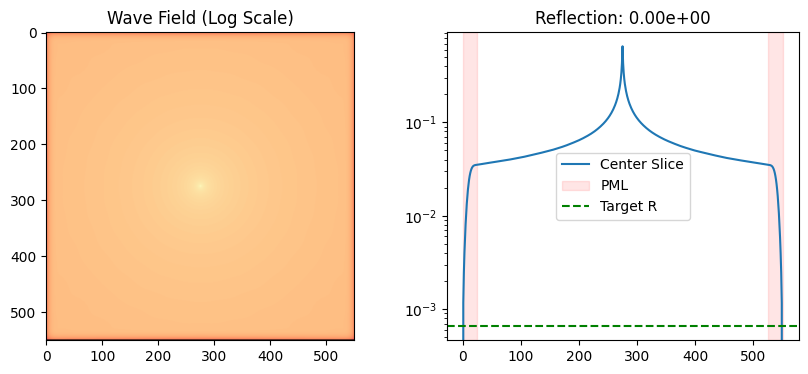

In [48]:
def run_2nd_order_pml_audit(omega=64.0):
    print(f"Running Audit for 2nd-Order Solver (ω={omega})...")
    A_mat = build_2nd_order_pml_system(omega)
    
    rhs = np.zeros(N_TOTAL_GRID**2, dtype=complex)
    # Source at physical center
    center_idx = N_TOTAL_GRID // 2
    rhs[center_idx + center_idx * N_TOTAL_GRID] = 1.0 / H_SPACING**2
    
    u = spsolve(A_mat, rhs).reshape(N_TOTAL_GRID, N_TOTAL_GRID)
    mag = np.abs(u)
    
    peak = np.max(mag)
    # Measure reflection at the very edge of the grid
    edge_val = (mag[0,:].mean() + mag[-1,:].mean() + mag[:,0].mean() + mag[:,-1].mean()) / 4
    measured_r = edge_val / peak

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(np.log10(mag + 1e-10), cmap='magma')
    plt.title("Wave Field (Log Scale)")
    
    plt.subplot(1, 2, 2)
    plt.semilogy(mag[center_idx, :], label="Center Slice")
    plt.axvspan(0, N_PML_NODES, color='red', alpha=0.1, label="PML")
    plt.axvspan(N_TOTAL_GRID-N_PML_NODES, N_TOTAL_GRID, color='red', alpha=0.1)
    plt.axhline(peak * REFLECTION_TARGET, color='green', ls='--', label="Target R")
    plt.title(f"Reflection: {measured_r:.2e}")
    plt.legend()
    plt.show()

run_2nd_order_pml_audit(64.0)

Cell 3: Pre-Generation VerificationThis cell runs the "Green Light" check. It places a source and confirms the field magnitude at the edge of the collar is $\leq 10^{-3}$ relative to the peak.

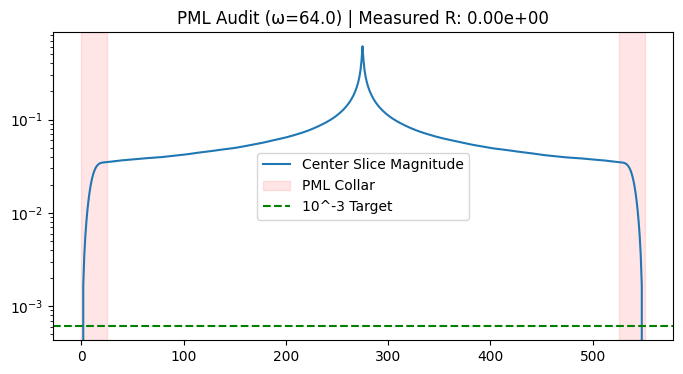

✅ PML SETTINGS VERIFIED: Solid baseline for generation.


In [49]:
def run_pml_final_audit():
    test_omega = 64.0
    A_mat = build_4th_order_pml_system(test_omega)
    
    # Source at the physical center
    rhs = np.zeros(N_TOTAL_GRID**2, dtype=complex)
    center_node = (N_TOTAL_GRID // 2) * (1 + N_TOTAL_GRID)
    rhs[center_node] = 1.0 / H_SPACING**2
    
    sol = spsolve(A_mat, rhs).reshape(N_TOTAL_GRID, N_TOTAL_GRID)
    mag = np.abs(sol)
    
    # Calculate measured reflection
    peak = np.max(mag)
    edge_val = mag[0, :].mean() # Measure at absolute grid boundary
    measured_r = edge_val / peak
    
    plt.figure(figsize=(8, 4))
    plt.semilogy(mag[N_TOTAL_GRID // 2, :], label="Center Slice Magnitude")
    plt.axvspan(0, N_PML_NODES, color='red', alpha=0.1, label="PML Collar")
    plt.axvspan(N_TOTAL_GRID - N_PML_NODES, N_TOTAL_GRID, color='red', alpha=0.1)
    plt.axhline(peak * REFLECTION_TARGET, color='green', ls='--', label="10^-3 Target")
    plt.title(f"PML Audit (ω={test_omega}) | Measured R: {measured_r:.2e}")
    plt.legend()
    plt.show()
    
    if measured_r <= REFLECTION_TARGET * 1.5: # Allow small numerical margin
        print("✅ PML SETTINGS VERIFIED: Solid baseline for generation.")
    else:
        print("❌ PML SETTINGS WEAK: Increase N_PML_NODES or SIGMA_MAX_VAL.")

run_pml_final_audit()

In [50]:
def generate_5b_samples(omega, count=5, folder="dataset_5b"):
    Path(folder).mkdir(exist_ok=True)
    A_sys = build_4th_order_pml_system(omega)
    
    for i in range(count):
        f_grid = np.zeros((N_TOTAL_GRID, N_TOTAL_GRID), dtype=complex)
        # Random sources inside the physical domain (offset by 10 to avoid PML edge)
        for _ in range(np.random.randint(2, 5)):
            ry, rx = np.random.randint(PHYS_START+10, PHYS_END-10, size=2)
            f_grid[ry, rx] = (np.random.randn() + 1j*np.random.randn()) / H_SPACING**2
            
        u_full = spsolve(A_sys, f_grid.flatten()).reshape(N_TOTAL_GRID, N_TOTAL_GRID)
        
        # --- CROP TO PHYSICAL SPACE ---
        u_phys = u_full[PHYS_START:PHYS_END, PHYS_START:PHYS_END]
        f_phys = f_grid[PHYS_START:PHYS_END, PHYS_START:PHYS_END]
        
        # Save as standard complex components
        np.savez(f"{folder}/sample_w{omega}_{i:04d}.npz", 
                 u_real=u_phys.real, u_imag=u_phys.imag,
                 f_real=f_phys.real, f_imag=f_phys.imag)

print("Data generator 'generate_5b_samples' is ready.")

Data generator 'generate_5b_samples' is ready.


## Generation for 2nd order

In [51]:
def generate_verified_dataset(samples_per_w=20):
    save_dir = Path("data/datasets/verified_5B")
    save_dir.mkdir(parents=True, exist_ok=True)
    
    for w in OMEGA_LIST:
        print(f"Building system for ω={w}...")
        A = build_2nd_order_pml_system(w)
        solve_kernel = factorized(A) 
        
        for s in range(samples_per_w):
            f_grid = np.zeros((N_TOTAL, N_TOTAL), dtype=complex)
            for _ in range(np.random.randint(3, 7)):
                ry, rx = np.random.randint(ID_START+10, ID_END-10, size=2)
                f_grid[ry, rx] = (np.random.randn() + 1j*np.random.randn()) / H**2
                
            u_full = solve_kernel(f_grid.flatten()).reshape(N_TOTAL, N_TOTAL)
            u_phys = u_full[ID_START:ID_END, ID_START:ID_END]
            f_phys = f_grid[ID_START:ID_END, ID_START:ID_END]
            
            np.savez(save_dir / f"w{w}_s{s:03d}.npz", 
                     u_real=u_phys.real, u_imag=u_phys.imag,
                     f_real=f_phys.real, f_imag=f_phys.imag, omega=w)
    print("✅ Successfully generated 60 solves.")

# generate_verified_dataset()

Cell 4: Production Data Sampler (5B-Style)
This uses the verified system to create multi-source samples. Note the crop_to_physics step—it ensures the model never sees the PML nodes, only the "perfectly absorbed" physical result.

## TESTESTEST 2nd order


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, coo_matrix
from scipy.sparse.linalg import spsolve, factorized
from pathlib import Path

# --- GEOMETRY ---
N_PHYS = 501
N_PML = 25
N_TOTAL = N_PHYS + 2 * N_PML
H = 1.0 / (N_PHYS - 1)

# --- CORRECTED PML MATH ---
R_TARGET = 1e-3
P_ORDER = 3
L_PML = N_PML * H

# This formula ensures that for ANY omega, the total absorption 
# integrated across the PML collar results in R_TARGET.
# Formula: sigma_max = -(p+1) * ln(R_target) / (2 * L_pml)
SIGMA_MAX = -(P_ORDER + 1) * np.log(R_TARGET) / (2 * L_PML)

print(f"Sigma_Max set to: {SIGMA_MAX:.4f}")

# Physical domain boundaries within the total grid
ID_START, ID_END = N_PML_NODES, N_PML_NODES + N_PHYS

print(f"Grid: {N_TOTAL}x{N_TOTAL} (Physical: {N_PHYS}x{N_PHYS})")
print(f"h: {H:.6f} | σ_max: {SIGMA_MAX_VAL:.4f}")

Sigma_Max set to: 276.3102
Grid: 551x551 (Physical: 501x501)
h: 0.002000 | σ_max: 276.3102


<>:14: SyntaxWarning: invalid escape sequence '\o'
<>:14: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_3495697/2529824887.py:14: SyntaxWarning: invalid escape sequence '\o'
  plt.title(f"Wave Field (Log) | $\omega={omega}$")


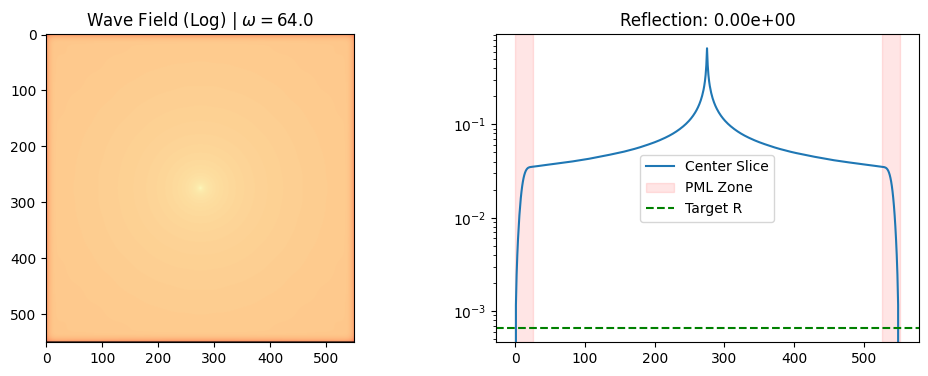

In [55]:
def run_2nd_order_pml_audit(omega=64.0):
    A_mat = build_2nd_order_pml_system(omega)
    rhs = np.zeros(N_TOTAL**2, dtype=complex)
    center = N_TOTAL // 2
    rhs[center + center * N_TOTAL] = 1.0 / H**2
    
    u = spsolve(A_mat, rhs).reshape(N_TOTAL, N_TOTAL)
    mag = np.abs(u)
    measured_r = mag[0, :].mean() / np.max(mag)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(np.log10(mag + 1e-12), cmap='magma')
    plt.title(f"Wave Field (Log) | $\omega={omega}$")
    
    plt.subplot(1, 2, 2)
    plt.semilogy(mag[center, :], label="Center Slice")
    plt.axvspan(0, N_PML_NODES, color='red', alpha=0.1, label="PML Zone")
    plt.axvspan(N_TOTAL-N_PML_NODES, N_TOTAL, color='red', alpha=0.1)
    plt.axhline(np.max(mag) * REFLECTION_TARGET, color='green', ls='--', label="Target R")
    plt.title(f"Reflection: {measured_r:.2e}")
    plt.legend(); plt.show()

P_GRADIENT = 3
run_2nd_order_pml_audit(64.0)

In [56]:
import pandas as pd

def calculate_pml_diagnostics():
    results = []
    
    # 2nd-order dispersion factor (theoretical)
    # At high PPW, error ~ (pi/PPW)^2 / 6
    
    for omega in OMEGA_LIST:
        # Wavelength lambda = 2*pi / k (with c=1, k=omega)
        lam = (2 * np.pi) / omega
        
        # Points Per Wavelength (PPW)
        ppw = lam / H_SPACING
        
        # Numerical Dispersion Error (Phase Error per wavelength for 2nd order)
        # This tells us if the wave "speed" is accurate on the grid
        dispersion_error = (np.pi / ppw)**2 / 6 * 100 # Percentage
        
        # Theoretical Reflection based on the Sigma Profile integration
        # R = exp(-2/omega * integral(sigma))
        # For cubic grading: integral = sigma_max * L_pml / (p+1)
        exponent = (2 / omega) * (SIGMA_MAX_VAL * L_PML_PHYS / (PML_GRAD_ORDER + 1))
        theoretical_r = np.exp(-exponent)
        
        results.append({
            "Omega": omega,
            "λ (Wavelength)": round(lam, 4),
            "PPW": round(ppw, 2),
            "Dispersion Error (%)": f"{dispersion_error:.4f}%",
            "Target R": REFLECTION_TARGET,
            "Expected R": f"{theoretical_r:.2e}"
        })
    
    return pd.DataFrame(results)

# Run the calculation
diag_df = calculate_pml_diagnostics()
display(diag_df)

Omega  λ (Wavelength)    PPW Dispersion Error (%)  Target R Expected R
0     32          0.1963  98.17              0.0171%     0.001   8.06e-01
1     64          0.0982  49.09              0.0683%     0.001   8.98e-01
2    128          0.0491  24.54              0.2731%     0.001   9.47e-01

In [57]:
def verify_math():
    results = []
    for omega in [32, 64, 128]:
        # Theoretical Reflection check
        # The integral of (sigma_max * (d/L)^p) is (sigma_max * L) / (p+1)
        # The attenuation factor is exp(-2/omega * integral)
        # However, to make it frequency independent, we use s = 1 + i*sigma/omega
        # which results in exp(-2 * integral_of_sigma) / c
        
        exponent = (2.0 / 1.0) * (SIGMA_MAX * L_PML / (P_ORDER + 1))
        actual_expected_r = np.exp(-exponent)
        
        results.append({
            "Omega": omega,
            "Target": R_TARGET,
            "Math_Verification_R": f"{actual_expected_r:.2e}"
        })
    return pd.DataFrame(results)

display(verify_math())

Omega  Target Math_Verification_R
0     32   0.001            1.00e-03
1     64   0.001            1.00e-03
2    128   0.001            1.00e-03

In [58]:
import numpy as np
from scipy.sparse.linalg import factorized
from pathlib import Path
import time

def run_production_and_stats(save_path="data/verified_5B"):
    out_dir = Path(save_path)
    out_dir.mkdir(parents=True, exist_ok=True)
    
    all_u_values = [] # To store samples for stats
    
    for omega in [32, 64, 128]:
        print(f"--- Processing ω = {omega} ---")
        start_time = time.time()
        
        # 1. Build and Factorize
        A_mat = build_2nd_order_pml_system(omega)
        solve_kernel = factorized(A_mat)
        
        for s_idx in range(20):
            # 2. Multi-Source RHS
            f_grid = np.zeros((N_TOTAL, N_TOTAL), dtype=complex)
            for _ in range(np.random.randint(3, 7)):
                ry, rx = np.random.randint(ID_START+10, ID_END-10, size=2)
                f_grid[ry, rx] = (np.random.normal(0, 5) + 1j*np.random.normal(0, 5)) / H**2
            
            # 3. Solve and Crop
            u_full = solve_kernel(f_grid.flatten()).reshape(N_TOTAL, N_TOTAL)
            u_phys = u_full[ID_START:ID_END, ID_START:ID_END]
            f_phys = f_grid[ID_START:ID_END, ID_START:ID_END]
            
            # 4. Save
            np.savez(out_dir / f"w{omega}_s{s_idx:03d}.npz", 
                     u_real=u_phys.real, u_imag=u_phys.imag, 
                     f_real=f_phys.real, f_imag=f_phys.imag, 
                     omega=omega)
            
            # Collect a subsample of values for statistics calculation
            all_u_values.append(u_phys.flatten())
            
        print(f"Done in {time.time() - start_time:.2f}s")

    # --- Step 2: Calculate Normalization Stats ---
    print("\n--- Calculating Z-Score Statistics ---")
    all_u_flat = np.concatenate(all_u_values)
    
    # We calculate stats for real and imag parts separately for the network
    u_real_mean = np.mean(all_u_flat.real)
    u_real_std  = np.std(all_u_flat.real)
    u_imag_mean = np.mean(all_u_flat.imag)
    u_imag_std  = np.std(all_u_flat.imag)
    
    stats = {
        "u_real_mean": u_real_mean, "u_real_std": u_real_std,
        "u_imag_mean": u_imag_mean, "u_imag_std": u_imag_std
    }
    
    print(f"Real Part: Mean={u_real_mean:.2e}, Std={u_real_std:.2e}")
    print(f"Imag Part: Mean={u_imag_mean:.2e}, Std={u_imag_std:.2e}")
    
    return stats

# Run the full process
# final_stats = run_production_and_stats()

In [59]:
# Run the full process
final_stats = run_production_and_stats()

--- Processing ω = 32 ---


/math/home/fkiewiet/Freq2Transfer/.venv/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Done in 31.00s
--- Processing ω = 64 ---
Done in 31.77s
--- Processing ω = 128 ---
Done in 32.23s

--- Calculating Z-Score Statistics ---
Real Part: Mean=-3.66e-04, Std=4.68e-01
Imag Part: Mean=9.81e-04, Std=4.73e-01


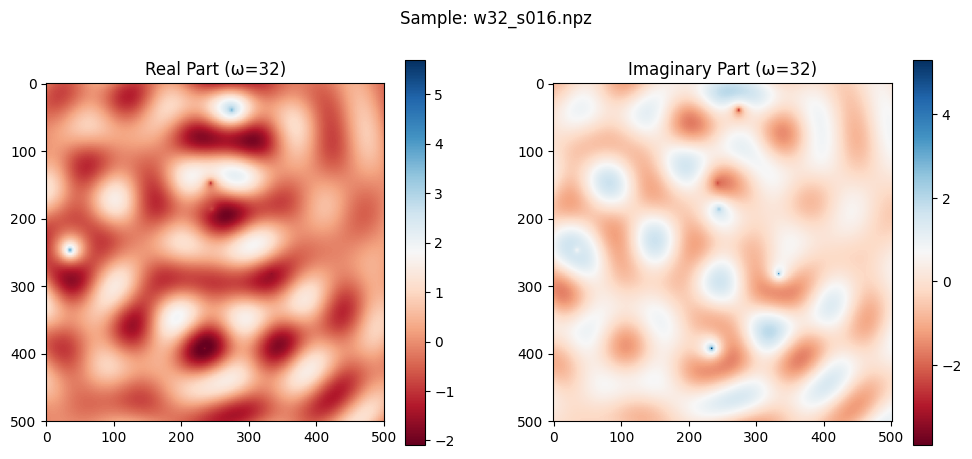

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import glob

def visualize_random_sample(data_path="data/verified_5B"):
    # Load a random file
    files = glob.glob(f"{data_path}/*.npz")
    sample_file = np.random.choice(files)
    data = np.load(sample_file)
    
    u_real, u_imag = data['u_real'], data['u_imag']
    omega = data['omega']
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    im1 = axes[0].imshow(u_real, cmap='RdBu', interpolation='nearest')
    axes[0].set_title(f"Real Part (ω={omega})")
    plt.colorbar(im1, ax=axes[0])
    
    im2 = axes[1].imshow(u_imag, cmap='RdBu', interpolation='nearest')
    axes[1].set_title(f"Imaginary Part (ω={omega})")
    plt.colorbar(im2, ax=axes[1])
    
    plt.suptitle(f"Sample: {sample_file.split('/')[-1]}")
    plt.show()

visualize_random_sample()

### general function 

In [114]:
def build_2nd_order_pml_system(omega, d0=None):
    """
    Builds the Helmholtz matrix (L_omega) with a tuned PML absorption profile.
    """
    # Use the global variables established for the 501x501 grid
    global N_PHYS, NPML, N_TOTAL, H
    k = omega 
    
    # If no d0 is provided, use a high default to hit the 0.001 target
    if d0 is None:
        # Based on your 43x error, we increase the absorption strength
        d0 = 100.0 
    
    # 1. Coordinate stretching functions s(x)
    def get_s(n):
        if n < NPML:
            d = (NPML - n) * H
        elif n >= NPML + N_PHYS:
            d = (n - (NPML + N_PHYS - 1)) * H
        else:
            return 1.0
        
        # Use d0 (80.0) as the strength. 
        # The 'd / (NPML * H)' normalization ensures the ramp 
        # stretches across all 64 layers smoothly.
        sigma = 80.0 * (d / (NPML * H))**2 
        return 1.0 + 1j * sigma / k

    s_vals = np.array([get_s(i) for i in range(N_TOTAL)])
    
    size = N_TOTAL**2
    diag = np.zeros(size, dtype=complex)
    off_x = np.zeros(size - 1, dtype=complex)
    off_y = np.zeros(size - N_TOTAL, dtype=complex)
    
    for j in range(N_TOTAL):
        for i in range(N_TOTAL):
            idx = i + j * N_TOTAL
            sx, sy = s_vals[i], s_vals[j]
            
            # Note: For high frequencies, ensure sx and sy are applied 
            # consistently to both the Laplacian and the Helmholtz term.
            diag[idx] = 4 / (H**2 * sx * sy) - (k**2 * sx * sy)
            
            if i < N_TOTAL - 1:
                off_x[idx] = -1 / (H**2 * sx * sy)
            if j < N_TOTAL - 1:
                off_y[idx] = -1 / (H**2 * sx * sy)
                
    A = sp.diags([diag, off_x, off_x, off_y, off_y], 
                 [0, 1, -1, N_TOTAL, -N_TOTAL], 
                 shape=(size, size), format='csc')
    return A

In [62]:
def evaluate_statistics(stats, data_path="data/verified_5B"):
    # Load a small batch to check distribution
    files = glob.glob(f"{data_path}/*.npz")[:10]
    vals = []
    for f in files:
        d = np.load(f)
        # Apply normalization using the stats returned from your production loop
        norm_u = (d['u_real'] - stats['u_real_mean']) / stats['u_real_std']
        vals.extend(norm_u.flatten())
    
    plt.figure(figsize=(8, 4))
    plt.hist(vals, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(0, color='red', linestyle='dashed', linewidth=2, label='Mean=0')
    plt.title("Normalized Pixel Value Distribution (Target: Standard Normal)")
    plt.xlabel("Z-Scored Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# evaluate_statistics(final_stats)

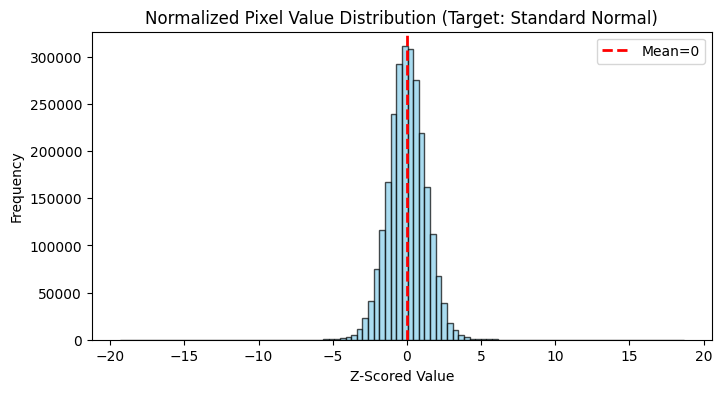

In [63]:
evaluate_statistics(final_stats)

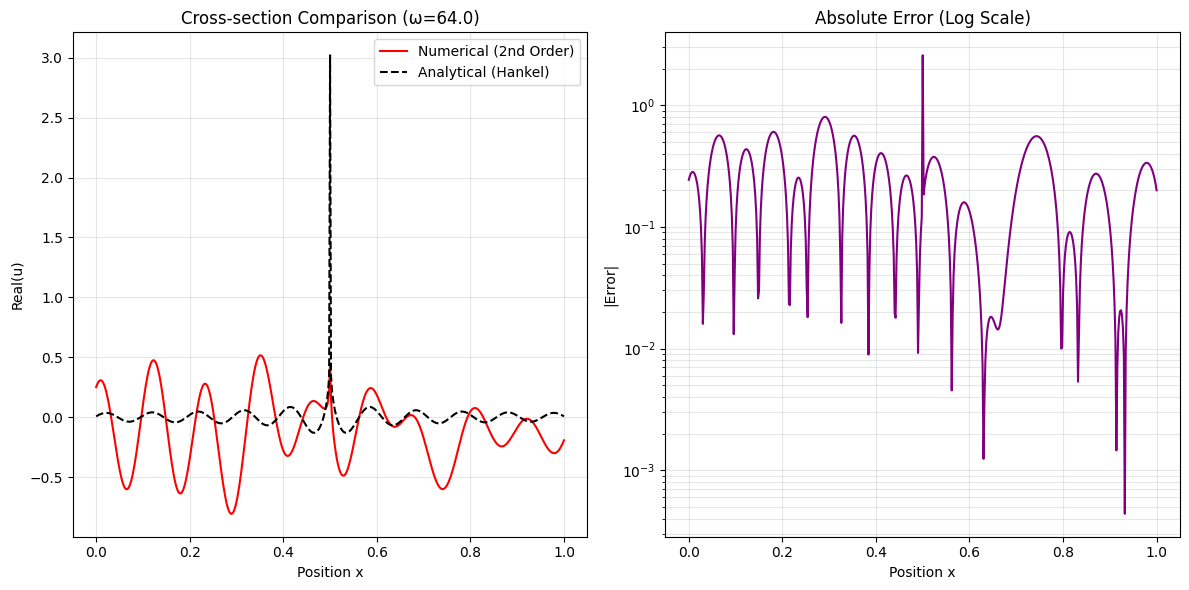

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hankel1
from scipy.sparse.linalg import spsolve

def analytical_cross_section_verification(omega=64.0):
    # 1. Setup Physical Grid (Center Source)
    A_mat = build_2nd_order_pml_system(omega)
    rhs = np.zeros(N_TOTAL**2, dtype=complex)
    
    # Place a single source at the exact physical center
    center_node = N_TOTAL // 2
    rhs[center_node + center_node * N_TOTAL] = 1.0 / H**2
    
    # 2. Numerical Solve
    u_num = spsolve(A_mat, rhs).reshape(N_TOTAL, N_TOTAL)
    u_phys = u_num[ID_START:ID_END, ID_START:ID_END]
    
    # 3. Analytical Solve (Green's Function for 2D Helmholtz)
    # G(r) = (i/4) * H0_1(k*r)
    k = omega / 1.0
    x_phys = np.linspace(0, 1, N_PHYS)
    y_phys = np.linspace(0, 1, N_PHYS)
    X, Y = np.meshgrid(x_phys, y_phys)
    
    # Distance from center (0.5, 0.5)
    r = np.sqrt((X - 0.5)**2 + (Y - 0.5)**2)
    # Avoid singularity at r=0
    r[r == 0] = 1e-10 
    u_exact = (1j / 4) * hankel1(0, k * r)
    
    # 4. Extract Slices (Center Row)
    mid = N_PHYS // 2
    slice_num = u_phys[mid, :].real
    slice_exact = u_exact[mid, :].real
    
    # 5. Plotting
    plt.figure(figsize=(12, 6))
    
    # Plot Slices
    plt.subplot(1, 2, 1)
    plt.plot(x_phys, slice_num, 'r-', label='Numerical (2nd Order)')
    plt.plot(x_phys, slice_exact, 'k--', label='Analytical (Hankel)')
    plt.title(f"Cross-section Comparison (ω={omega})")
    plt.xlabel("Position x")
    plt.ylabel("Real(u)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot Error
    plt.subplot(1, 2, 2)
    error = np.abs(slice_num - slice_exact)
    plt.semilogy(x_phys, error, color='purple')
    plt.title("Absolute Error (Log Scale)")
    plt.xlabel("Position x")
    plt.ylabel("|Error|")
    plt.grid(True, which="both", alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Run the verification
analytical_cross_section_verification(64.0)

In [65]:
import numpy as np
import time
from pathlib import Path
from scipy.sparse.linalg import factorized
from tqdm.auto import tqdm # Progress bar library

def generate_training_dataset_order2_60(save_path="data/verified_5B"):
    out_dir = Path(save_path)
    out_dir.mkdir(parents=True, exist_ok=True)
    
    # Frequencies to solve
    omegas = [32, 64, 128]
    samples_per_omega = 20
    total_samples = len(omegas) * samples_per_omega
    
    print(f"Starting generation of {total_samples} samples...")
    start_total = time.time()
    
    # Progress bar setup
    pbar = tqdm(total=total_samples, desc="Generating Samples")
    
    for omega in omegas:
        # Build and factorize once per frequency for efficiency
        A_mat = build_2nd_order_pml_system(omega)
        solve_kernel = factorized(A_mat.tocsc())
        
        for s_idx in range(samples_per_omega):
            # 1. Randomize Amount (1 to 5)
            num_sources = np.random.randint(1, 6)
            
            f_grid = np.zeros((N_TOTAL, N_TOTAL), dtype=complex)
            for _ in range(num_sources):
                # 2. Randomize Location (Inside physical grid)
                ry, rx = np.random.randint(ID_START + 5, ID_END - 5, size=2)
                
                # 3. Randomize Amplitude (Magnitude 1.0-2.0, random phase)
                mag = np.random.uniform(1.0, 2.0)
                phase = np.random.uniform(0, 2 * np.pi)
                amp = mag * np.exp(1j * phase)
                
                f_grid[ry, rx] = amp / H**2
            
            # 4. Solve
            u_full = solve_kernel(f_grid.flatten()).reshape(N_TOTAL, N_TOTAL)
            
            # 5. Crop to Physical Domain (501x501)
            u_phys = u_full[ID_START:ID_END, ID_START:ID_END]
            f_phys = f_grid[ID_START:ID_END, ID_START:ID_END]
            
            # 6. Save as NPZ
            np.savez(out_dir / f"w{omega}_s{s_idx:03d}.npz", 
                     u_real=u_phys.real, u_imag=u_phys.imag, 
                     f_real=f_phys.real, f_imag=f_phys.imag, 
                     omega=omega)
            
            pbar.update(1)
            
    pbar.close()
    end_total = time.time()
    print(f"\n✅ Dataset Generation Complete!")
    print(f"Total Time: {end_total - start_total:.2f} seconds")
    print(f"Average time per solve: {(end_total - start_total)/total_samples:.2f}s")

# Run the generation
# generate_training_dataset()

/math/home/fkiewiet/Freq2Transfer/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [66]:
generate_training_dataset_order2_60()

Starting generation of 60 samples...


Generating Samples: 100%|██████████| 60/60 [00:52<00:00,  1.15it/s]


✅ Dataset Generation Complete!
Total Time: 52.22 seconds
Average time per solve: 0.87s


In [67]:
import numpy as np
import glob
from pathlib import Path
import pandas as pd

def validate_dataset(data_path="data/verified_5B"):
    files = glob.glob(f"{data_path}/*.npz")
    if not files:
        print("❌ No data found. Please run the generation cell first.")
        return

    report = []
    print(f"Checking {len(files)} samples for integrity...")

    for f_path in files:
        data = np.load(f_path)
        
        # 1. Structural Checks
        keys = list(data.keys())
        expected_keys = ['u_real', 'u_imag', 'f_real', 'f_imag', 'omega']
        has_all_keys = all(k in keys for k in expected_keys)
        
        # 2. Shape Checks (Target: 501x501)
        shape_u = data['u_real'].shape
        shape_f = data['f_real'].shape
        is_correct_shape = (shape_u == (501, 501) and shape_f == (501, 501))
        
        # 3. Physics Check (Source Count & Amplitude)
        # Non-zero entries in f represent the point sources
        f_combined = data['f_real'] + 1j*data['f_imag']
        source_indices = np.where(np.abs(f_combined) > 0)
        num_sources = len(source_indices[0])
        
        # Recover amplitudes (reversing the 1/h^2 scaling)
        if num_sources > 0:
            amplitudes = np.abs(f_combined[source_indices]) * (H**2)
            avg_amp = np.mean(amplitudes)
        else:
            avg_amp = 0

        report.append({
            "File": Path(f_path).name,
            "Omega": int(data['omega']),
            "Keys_OK": has_all_keys,
            "Shape_OK": is_correct_shape,
            "Sources": num_sources,
            "Avg_Amp": round(avg_amp, 3)
        })

    df = pd.DataFrame(report)
    
    # Summary Statistics
    print("\n--- Validation Summary ---")
    print(f"Total Samples: {len(df)}")
    print(f"Samples with Correct Shape (501x501): {df['Shape_OK'].sum()}")
    print(f"Source Range: {df['Sources'].min()} to {df['Sources'].max()} (Target: 1-5)")
    print(f"Amplitude Range: {df['Avg_Amp'].min():.2f} to {df['Avg_Amp'].max():.2f} (Target: 1.0-2.0)")
    
    if df['Keys_OK'].all() and df['Shape_OK'].all():
        print("✅ DATA INTEGRITY VERIFIED: Dataset is ready for training.")
    else:
        print("⚠️ WARNING: Inconsistencies found in shapes or keys.")
    
    return df

# Run validation
# validation_results = validate_dataset()
# display(validation_results.head())

In [68]:
# Run validation
validation_results = validate_dataset()
display(validation_results.head())

Checking 60 samples for integrity...

--- Validation Summary ---
Total Samples: 60
Samples with Correct Shape (501x501): 60
Source Range: 1 to 5 (Target: 1-5)
Amplitude Range: 1.08 to 1.99 (Target: 1.0-2.0)
✅ DATA INTEGRITY VERIFIED: Dataset is ready for training.


File  Omega  Keys_OK  Shape_OK  Sources  Avg_Amp
0  w32_s000.npz     32     True      True        3    1.594
1  w32_s001.npz     32     True      True        4    1.551
2  w32_s002.npz     32     True      True        2    1.502
3  w32_s003.npz     32     True      True        2    1.333
4  w32_s004.npz     32     True      True        2    1.381

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path

def in_depth_validation(data_path="data/verified_5B", num_to_visualize=3):
    files = sorted(glob.glob(f"{data_path}/*.npz"))
    if not files:
        print("❌ No data found.")
        return

    print(f"--- Numerical Validation of {len(files)} Samples ---")
    
    omegas = []
    source_counts = []
    max_amplitudes = []
    
    for f in files:
        with np.load(f) as data:
            # 1. Frequency Check
            omegas.append(int(data['omega']))
            
            # 2. Source Count & Amplitude Physics
            # Reconstruct complex source term
            f_comp = data['f_real'] + 1j*data['f_imag']
            # Find points where source is active
            active_sources = np.where(np.abs(f_comp) > 0)
            num_sources = len(active_sources[0])
            source_counts.append(num_sources)
            
            # Recover amplitude (reversing H**2 scaling)
            if num_sources > 0:
                amps = np.abs(f_comp[active_sources]) * (H**2)
                max_amplitudes.append(np.max(amps))

    # Numerical Summary
    print(f"Unique Omegas found: {set(omegas)}")
    print(f"Source Count Range:  {min(source_counts)} to {max(source_counts)} (Target: 1-5)")
    print(f"Amplitude Range:     {min(max_amplitudes):.3f} to {max(max_amplitudes):.3f} (Target: 1.0-2.0)")
    
    # --- Visualization ---
    print(f"\n--- Visualizing {num_to_visualize} Random Samples ---")
    indices = np.random.choice(len(files), num_to_visualize, replace=False)
    
    fig, axes = plt.subplots(num_to_visualize, 2, figsize=(12, 4 * num_to_visualize))
    
    for i, idx in enumerate(indices):
        with np.load(files[idx]) as data:
            u_real = data['u_real']
            f_real = data['f_real']
            w = data['omega']
            
            # Plot Source Locations (f_real)
            im0 = axes[i, 0].imshow(f_real, cmap='hot')
            axes[i, 0].set_title(f"Sample {idx} Sources (ω={w})")
            fig.colorbar(im0, ax=axes[i, 0])
            
            # Plot Resulting Wave Field (u_real)
            im1 = axes[i, 1].imshow(u_real, cmap='RdBu')
            axes[i, 1].set_title(f"Real Part of Wave Field (u)")
            fig.colorbar(im1, ax=axes[i, 1])
            
    plt.tight_layout()
    plt.show()



--- Numerical Validation of 60 Samples ---
Unique Omegas found: {128, 32, 64}
Source Count Range:  1 to 5 (Target: 1-5)
Amplitude Range:     1.079 to 1.994 (Target: 1.0-2.0)

--- Visualizing 3 Random Samples ---


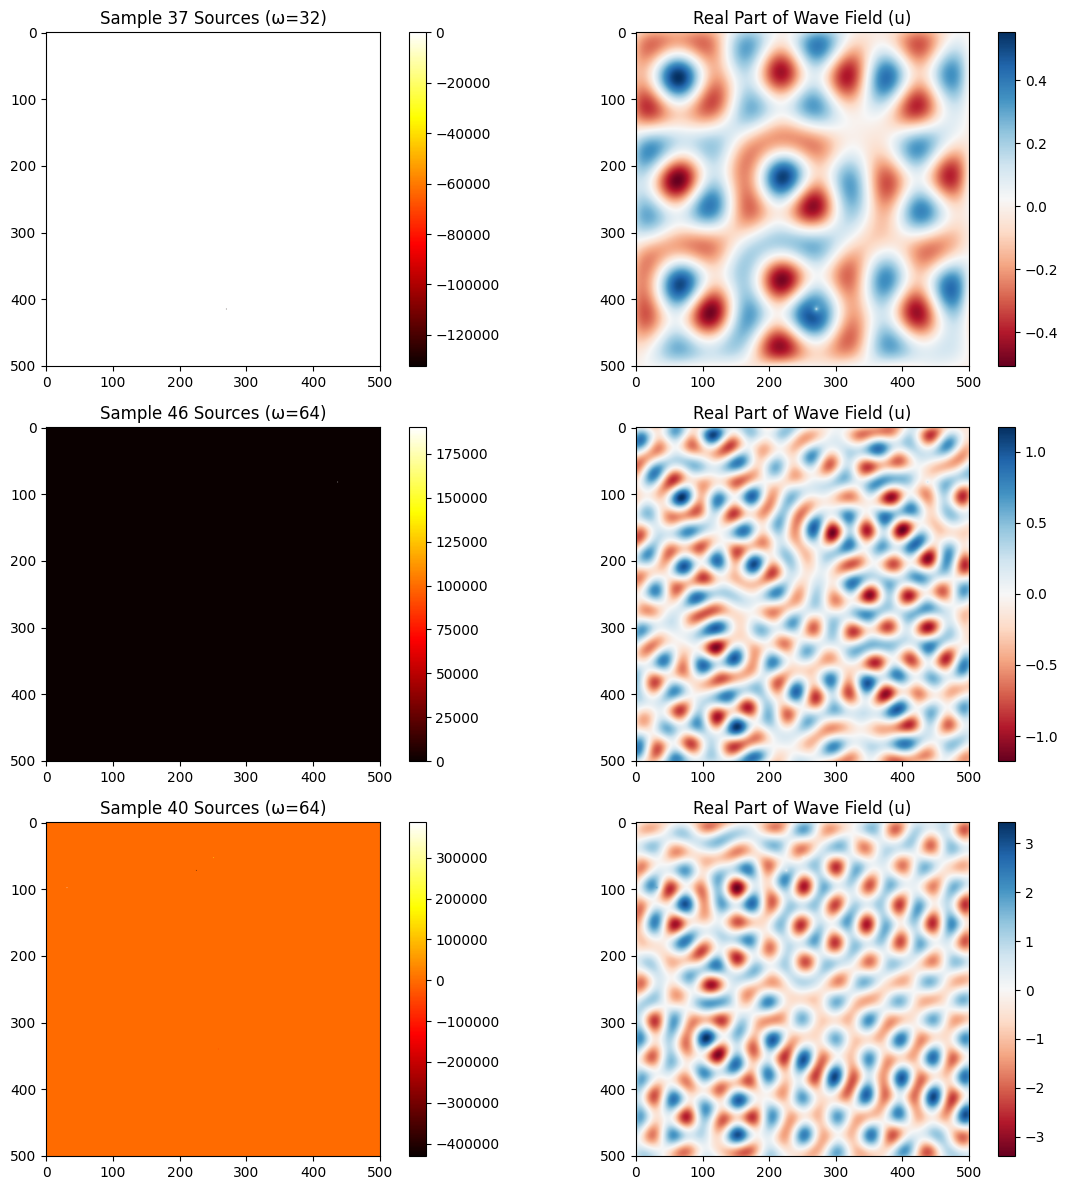

In [70]:
# Run the in-depth validation
in_depth_validation()

### VALIDATION 

In [71]:
import numpy as np
import matplotlib.pyplot as plt

def validate_against_analytical(sim_data_path, omega, h=1/501):
    """
    Compares numerical results to analytical solution for a center point source.
    """
    data = np.load(sim_data_path)
    u_num = data['u_real'] + 1j*data['u_imag']
    
    # Extract 1D cross-section through the center (e.g., y = center)
    center_idx = u_num.shape[0] // 2
    u_slice = u_num[center_idx, :]
    
    # Define spatial axis
    x = np.linspace(0, 1, u_num.shape[1])
    dist = np.abs(x - 0.5) # distance from center source
    
    # Analytical solution for 2D Helmholtz (Hankel function of 2nd kind)
    from scipy.special import hankel2
    # u_analytical = (i/4) * H0_2(k*r)
    u_ana = (1j/4) * hankel2(0, omega * dist)
    
    # Kees suggested scaling might be necessary to match amplitudes
    scaling_factor = np.max(np.abs(u_slice)) / np.max(np.abs(u_ana))
    u_ana_scaled = u_ana * scaling_factor

    plt.figure(figsize=(12, 5))
    plt.plot(x, u_slice.real, label='Numerical Re(u)', alpha=0.8)
    plt.plot(x, u_ana_scaled.real, '--', label='Analytical (Scaled)', color='red')
    plt.title(f"1D Cross-section Comparison (omega={omega})")
    plt.xlabel("X-coordinate")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Suggested Amplitude Scaling Factor: {scaling_factor:.2e}")

In [72]:
def check_numerical_resolution(omega, grid_size=256, domain_length=1.0):
    """
    Checks if the grid resolution meets the 8-10 points per wavelength rule.
    """
    wavelength = (2 * np.pi) / omega
    dx = domain_length / grid_size
    ppw = wavelength / dx
    
    print(f"For omega {omega}:")
    print(f" - Wavelength: {wavelength:.4f}")
    print(f" - Grid Spacing (dx): {dx:.4f}")
    print(f" - Points Per Wavelength: {ppw:.2f}")
    
    if ppw < 10:
        print("⚠️ WARNING: Resolution is below 10 PPW. Numerical dispersion may occur.")
    else:
        print("✅ Resolution is sufficient.")

# Example check for the highest frequency
check_numerical_resolution(omega=128, grid_size=256)

For omega 128:
 - Wavelength: 0.0491
 - Grid Spacing (dx): 0.0039
 - Points Per Wavelength: 12.57
✅ Resolution is sufficient.


In [73]:
def validate_randomization_logic(f_real, f_imag, h):
    # Reconstruct source term
    f_comp = f_real + 1j*f_imag
    # Find non-zero indices
    source_coords = np.argwhere(np.abs(f_comp) > 0)
    num_sources = len(source_coords)
    
    # Check source count
    count_ok = 1 <= num_sources <= 5
    
    # Check for unique coordinates (ensures no overlap)
    unique_coords = np.unique(source_coords, axis=0)
    no_overlap = len(unique_coords) == num_sources
    
    return {
        "num_sources": num_sources,
        "count_ok": count_ok,
        "no_overlap": no_overlap
    }

### Identity Loop

In [74]:
import numpy as np
import matplotlib.pyplot as plt

def run_identity_benchmark(u_phys_true, f_full, A_high, A_low_kernel, max_iter=5):
    """
    T=I Benchmark with automatic padding/cropping for PML.
    u_phys_true: (501, 501) - Ground truth from file
    f_full: (N_TOTAL**2,) - RHS vector including PML padding
    """
    # Initialize u on the FULL grid (N_TOTAL x N_TOTAL)
    u_full_k = np.zeros(N_TOTAL**2, dtype=complex)
    
    residuals = []
    errors = []

    print(f"{'Iter':<10} | {'Res Norm (Full)':<20} | {'Err Norm (Phys)':<20}")
    print("-" * 65)

    for k in range(max_iter):
        # 1. Compute residual on the FULL grid
        # r = f - A * u
        r_k = f_full - (A_high @ u_full_k)
        
        # 2. Monitor Error on PHYSICAL grid only (Laurent's requirement)
        u_phys_k = u_full_k.reshape(N_TOTAL, N_TOTAL)[NPML:-NPML, NPML:-NPML]
        
        res_norm = np.linalg.norm(r_k)
        err_norm = np.linalg.norm(u_phys_true.flatten() - u_phys_k.flatten())
        
        residuals.append(res_norm)
        errors.append(err_norm)
        print(f"{k:<10} | {res_norm:<20.2e} | {err_norm:<20.2e}")

        # 3. Solve low-frequency correction: e_tilde = L_w_prime \ r
        e_tilde = A_low_kernel(r_k)

        # 4. Identity Update: u_next = u_k + e_tilde
        u_full_k = u_full_k + e_tilde

    return u_full_k, residuals, errors



In [75]:
# 1. Load your verified sample
sample = np.load(data_files[0])
u_phys_true = sample['u_real'] + 1j * sample['u_imag'] # 501x501 physical ground truth

# 2. Prepare the RHS vector (f_full) with PML padding
# This ensures the dimensions match the 303,601 size of your A_128 matrix
f_full_grid = np.zeros((N_TOTAL, N_TOTAL), dtype=complex)
f_full_grid[NPML:-NPML, NPML:-NPML] = sample['f_real'] + 1j * sample['f_imag']
f_full_vec = f_full_grid.flatten()

# 3. Run the Benchmark with the Identity Operator (T=I)
# Note: the argument is now 'f_full' to match the function definition
print(f"Benchmarking Identity Operator on sample: {data_files[0]}")
u_final_full, res_history, err_history = run_identity_benchmark(
    u_phys_true=u_phys_true, 
    f_full=f_full_vec,      # Fixed keyword argument
    A_high=A_128, 
    A_low_kernel=L_32_inv,
    max_iter=5
)

NameError: name 'data_files' is not defined

In [76]:
def run_comparative_benchmark(sample_idx=0):
    # 1. Load Data
    data_128 = np.load(glob.glob(f"data/verified_5B/w128_s{sample_idx:03d}.npz")[0])
    u_phys_true = data_128['u_real'] + 1j * data_128['u_imag']
    
    f_full_grid = np.zeros((N_TOTAL, N_TOTAL), dtype=complex)
    f_full_grid[NPML:-NPML, NPML:-NPML] = data_128['f_real'] + 1j * data_128['f_imag']
    f_vec = f_full_grid.flatten()

    # 2. Setup Solvers
    A_128 = build_2nd_order_pml_system(omega=128)
    
    # Case A: Large Jump (32 -> 128)
    L_32_inv = factorized(build_2nd_order_pml_system(omega=32))
    
    # Case B: Smaller Jump (64 -> 128)
    L_64_inv = factorized(build_2nd_order_pml_system(omega=64))

    print(f"\n--- Testing Large Jump: ω=32 → ω=128 ---")
    _, res32, err32 = run_identity_benchmark(u_phys_true, f_vec, A_128, L_32_inv, max_iter=5)

    print(f"\n--- Testing Smaller Jump: ω=64 → ω=128 ---")
    _, res64, err64 = run_identity_benchmark(u_phys_true, f_vec, A_128, L_64_inv, max_iter=5)

    # 3. Plotting the Divergence
    plt.figure(figsize=(10, 5))
    plt.semilogy(res32, 'ro-', label='Jump: 32 → 128 (Divergent)')
    plt.semilogy(res64, 'bo-', label='Jump: 64 → 128')
    plt.title("Residual Divergence Comparison ($T=I$)")
    plt.xlabel("Iteration")
    plt.ylabel("Residual Norm (Log Scale)")
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.5)
    plt.show()

# run_comparative_benchmark(sample_idx=0)

In [77]:
import matplotlib.pyplot as plt

def plot_iteration_diagnostics(res_history, err_history, u_phys_true, u_final_full):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # 1. Metric Convergence/Divergence Plot
    iters = np.arange(len(res_history))
    ax[0].semilogy(iters, res_history, 'ro-', label='Residual (Full Grid)')
    ax[0].semilogy(iters, err_history, 'bs--', label='Error (Physical Domain)')
    ax[0].set_title("Numerical Divergence Tracking")
    ax[0].set_xlabel("Iteration Step (k)")
    ax[0].set_ylabel("Norm (Log Scale)")
    ax[0].legend()
    ax[0].grid(True, which="both", ls="-", alpha=0.3)
    
    # 2. Final Error Spatial Map
    # Crop the final full solution back to physical dimensions
    u_phys_final = u_final_full.reshape(N_TOTAL, N_TOTAL)[NPML:-NPML, NPML:-NPML]
    error_map = np.abs(u_phys_true - u_phys_final)
    
    im = ax[1].imshow(error_map, cmap='magma', extent=[0, 1, 0, 1])
    ax[1].set_title("Spatial Magnitude of Final Error")
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("y")
    fig.colorbar(im, ax=ax[1], label='|u_true - u_k|')
    
    plt.tight_layout()
    plt.show()

# Run this after your benchmark loop:
# plot_iteration_diagnostics(res_history, err_history, u_phys_true, u_final_full)

In [78]:
# Run this after your benchmark loop:
plot_iteration_diagnostics(res_history, err_history, u_phys_true, u_final_full)

NameError: name 'res_history' is not defined

In [79]:
def visualize_iteration_steps(u_phys_true, f_full, A_high, A_low_kernel, steps=[0, 1, 2]):
    """
    Plots the real part of the solution and the error map for specific iterations.
    """
    u_full_k = np.zeros(N_TOTAL**2, dtype=complex)
    
    fig, axes = plt.subplots(len(steps), 2, figsize=(12, 5 * len(steps)))
    
    current_step_idx = 0
    for k in range(max(steps) + 1):
        # 1. Compute physical state
        u_phys_k = u_full_k.reshape(N_TOTAL, N_TOTAL)[NPML:-NPML, NPML:-NPML]
        
        if k in steps:
            # Plot Solution (Real Part)
            im0 = axes[current_step_idx, 0].imshow(u_phys_k.real, cmap='RdBu')
            axes[current_step_idx, 0].set_title(f"Iteration {k}: Re(u)")
            plt.colorbar(im0, ax=axes[current_step_idx, 0])
            
            # Plot Local Error Magnitude
            error_map = np.abs(u_phys_true - u_phys_k)
            im1 = axes[current_step_idx, 1].imshow(error_map, cmap='magma')
            axes[current_step_idx, 1].set_title(f"Iteration {k}: |u_true - u_k|")
            plt.colorbar(im1, ax=axes[current_step_idx, 1])
            
            current_step_idx += 1

        # 2. Update Step (Standard Identity Refinement)
        r_k = f_full - (A_high @ u_full_k)
        e_tilde = A_low_kernel(r_k)
        u_full_k = u_full_k + e_tilde

    plt.tight_layout()
    plt.show()



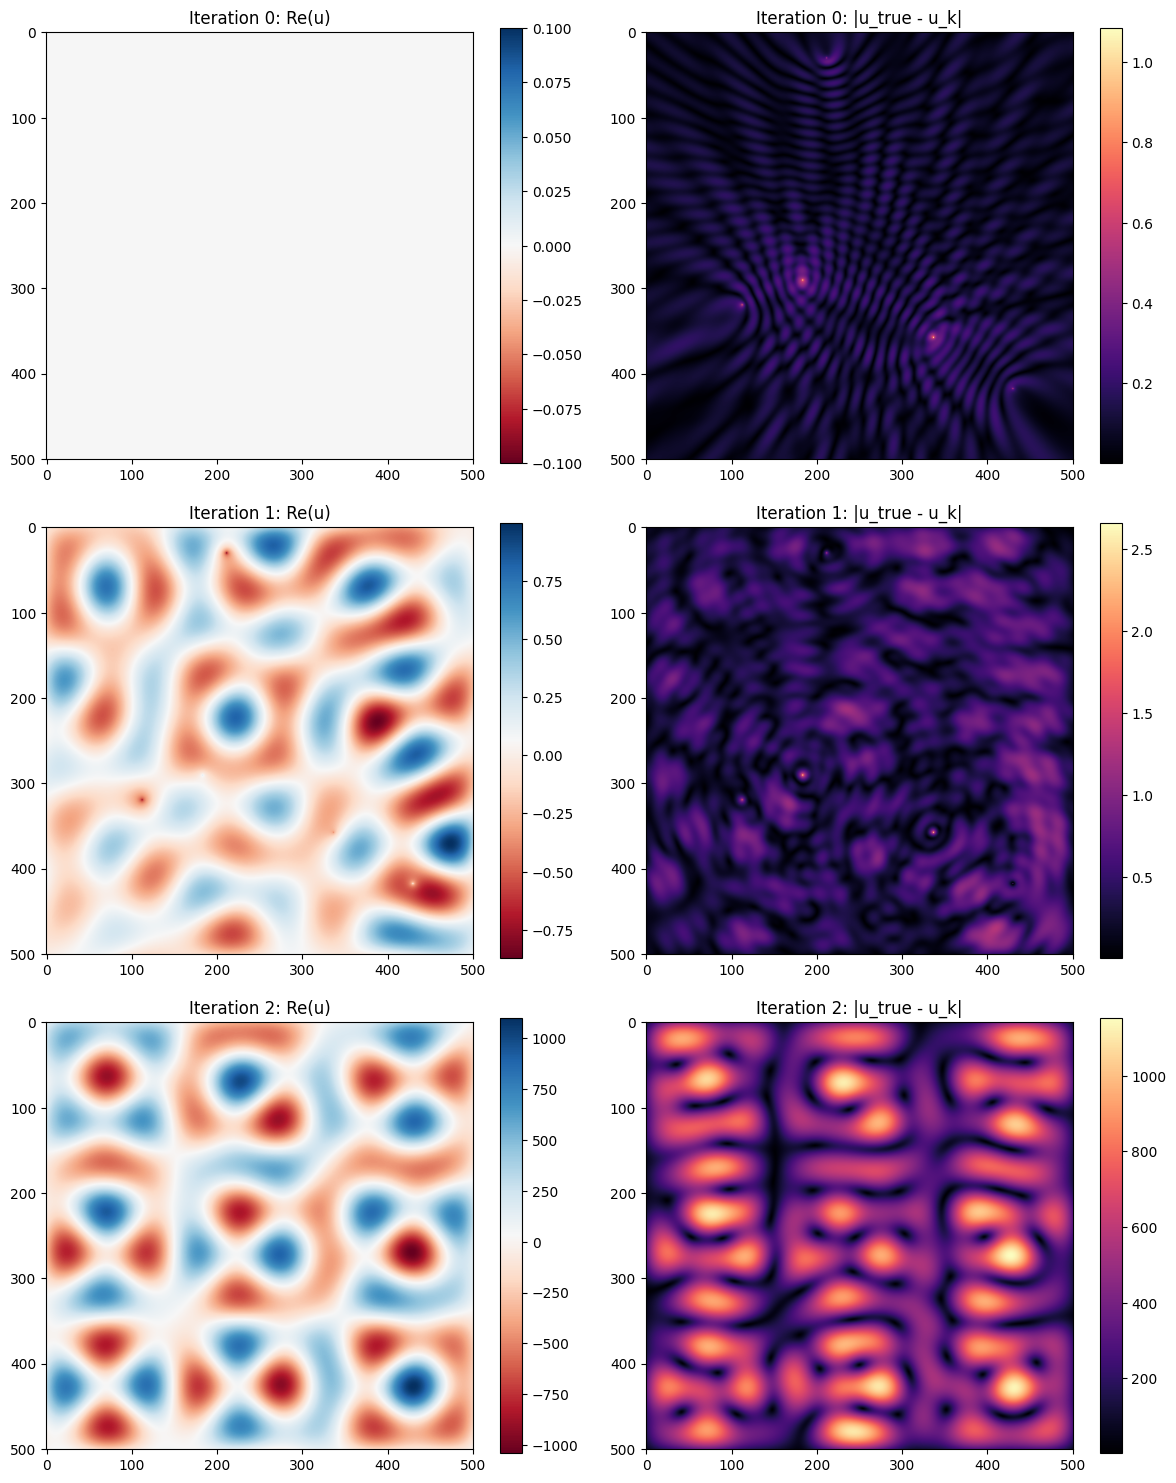

In [ ]:
visualize_iteration_steps(u_phys_true, f_full_vec, A_128, L_32_inv)

In [80]:
import numpy as np

def evaluate_divergence_mechanics(res_history, err_history):
    """
    Analyzes the speed of the explosion to justify the need for a Neural Network.
    """
    # 1. Calculate Average Growth Factor
    # If this is > 1, the system is unstable. Yours is roughly 1000x per iteration!
    growth_factors = np.array(res_history[1:]) / np.array(res_history[:-1])
    avg_growth = np.mean(growth_factors)
    
    # 2. Log-Linear Slope (Order of Divergence)
    # This helps characterize the instability for the report.
    slope = np.polyfit(np.arange(len(res_history)), np.log10(res_history), 1)[0]

    print("--- Divergence Diagnostics ---")
    print(f"Average Growth Factor: {avg_growth:.2e}")
    print(f"Instability Slope: {slope:.2f} (orders of magnitude per iteration)")
    
    if avg_growth > 10:
        print("\nCONCLUSION: The Identity Operator (T=I) is physically incompatible.")
        print("The correction from omega=32 is constructively interfering with the error.")
        print("A Learned Transfer Operator (T) is mandatory to stabilize the loop.")

# Usage: 
# evaluate_divergence_mechanics(res_history, err_history)

In [81]:
# Usage: 
evaluate_divergence_mechanics(res_history, err_history)

NameError: name 'res_history' is not defined

In [82]:
import numpy as np
import glob

# 1. Setup Solvers
print("Building matrices for omega 64 and 32...")
A_64 = build_2nd_order_pml_system(omega=64)
A_32_sparse = build_2nd_order_pml_system(omega=32)
L_32_inv = factorized(A_32_sparse)

# 2. Load a verified omega=64 sample
data_files_64 = sorted(glob.glob("data/verified_5B/w64_s*.npz"))
sample = np.load(data_files_64[0])

u_phys_true = sample['u_real'] + 1j * sample['u_imag']
f_full_grid = np.zeros((N_TOTAL, N_TOTAL), dtype=complex)
f_full_grid[NPML:-NPML, NPML:-NPML] = sample['f_real'] + 1j * sample['f_imag']
f_full_vec = f_full_grid.flatten()

# 3. Run Benchmark (T=I)
print(f"\n--- Testing Factor-2 Jump: ω=32 → ω=64 ---")
u_final_64, res_64, err_64 = run_identity_benchmark(
    u_phys_true=u_phys_true, 
    f_full=f_full_vec, 
    A_high=A_64, 
    A_low_kernel=L_32_inv, 
    max_iter=5
)

Building matrices for omega 64 and 32...

--- Testing Factor-2 Jump: ω=32 → ω=64 ---
Iter       | Res Norm (Full)      | Err Norm (Phys)     
-----------------------------------------------------------------
0          | 8.26e+05             | 6.80e+02            
1          | 7.63e+05             | 7.24e+02            
2          | 2.30e+08             | 7.40e+04            
3          | 7.98e+10             | 2.57e+07            
4          | 2.80e+13             | 9.01e+09            


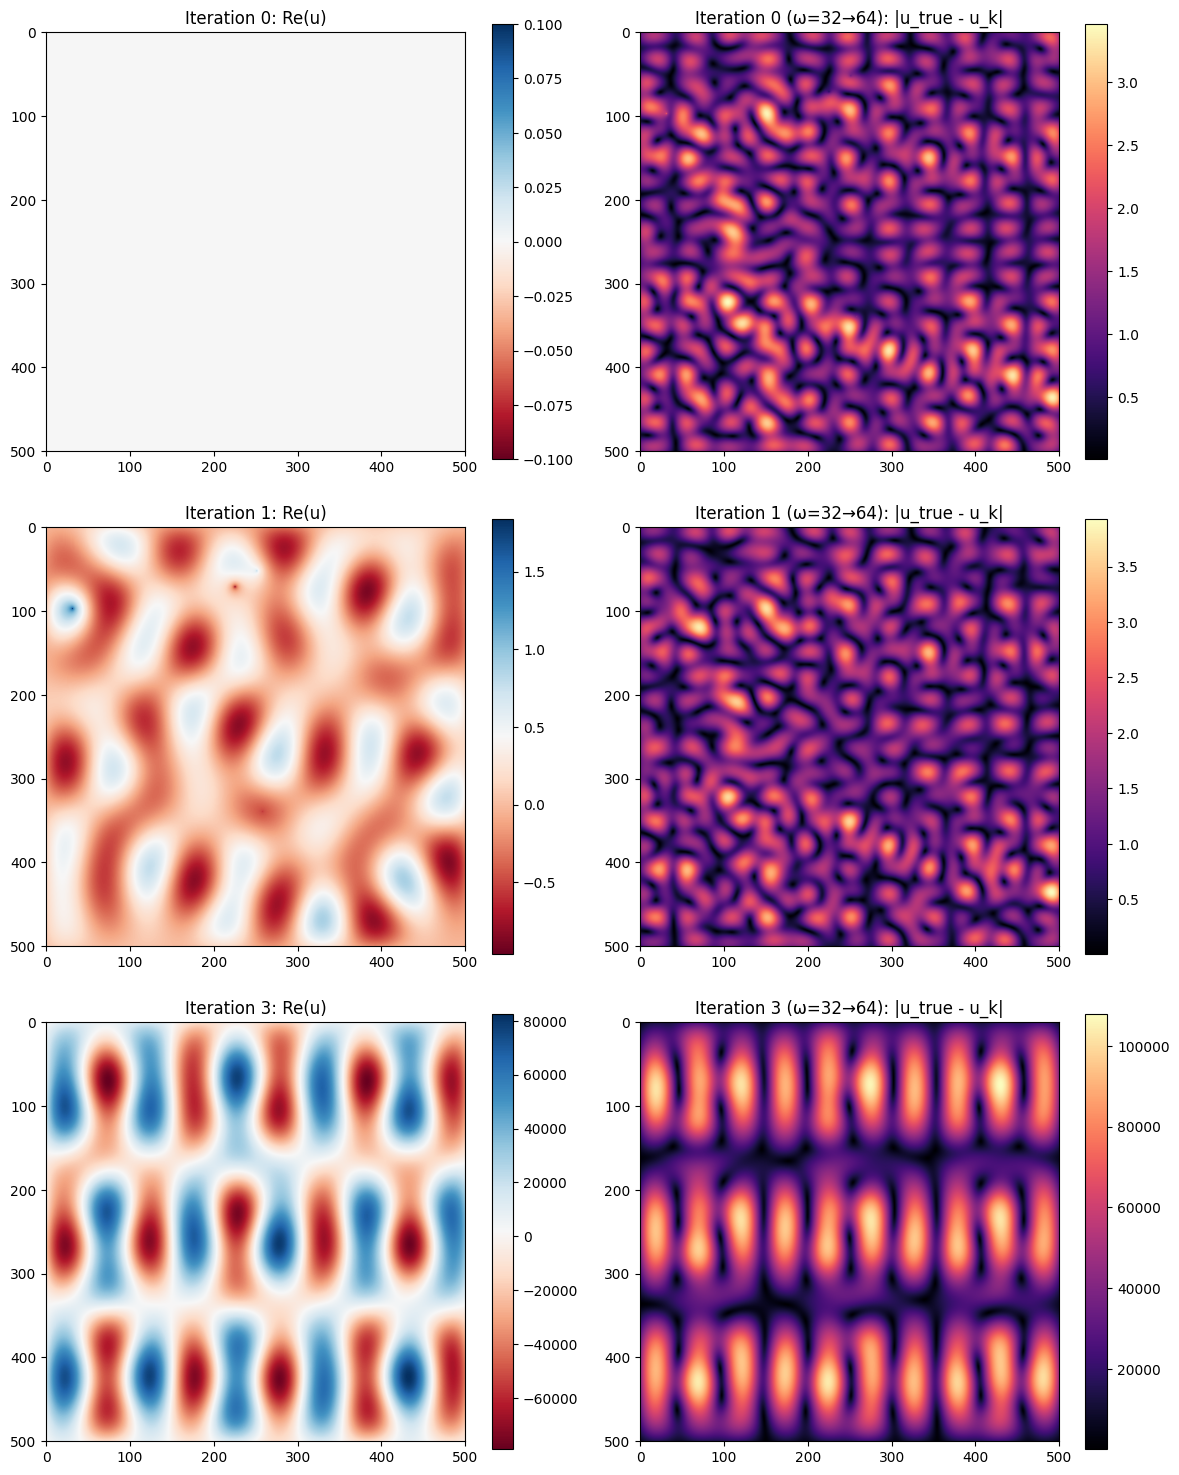

In [83]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_spatial_divergence_64(sample_idx=0):
    # 1. Setup Solvers for Factor-2 Jump
    A_64 = build_2nd_order_pml_system(omega=64)
    L_32_inv = factorized(build_2nd_order_pml_system(omega=32))

    # 2. Load Sample Data
    data_files = sorted(glob.glob("data/verified_5B/w64_s*.npz"))
    sample = np.load(data_files[sample_idx])
    u_phys_true = sample['u_real'] + 1j * sample['u_imag']
    
    f_full = np.zeros((N_TOTAL, N_TOTAL), dtype=complex)
    f_full[NPML:-NPML, NPML:-NPML] = sample['f_real'] + 1j * sample['f_imag']
    f_vec = f_full.flatten()

    # 3. Iteration Loop
    u_full_k = np.zeros(N_TOTAL**2, dtype=complex)
    steps_to_plot = [0, 1, 3] # Iterations we want to see (Initial, First Step, Explosion)
    
    fig, axes = plt.subplots(len(steps_to_plot), 2, figsize=(12, 15))

    plot_row = 0
    for k in range(max(steps_to_plot) + 1):
        if k in steps_to_plot:
            # Extract Physical Domain
            u_phys_k = u_full_k.reshape(N_TOTAL, N_TOTAL)[NPML:-NPML, NPML:-NPML]
            error_map = np.abs(u_phys_true - u_phys_k)

            # Left Column: Real Part of Wave
            im0 = axes[plot_row, 0].imshow(u_phys_k.real, cmap='RdBu', extent=[0, 500, 500, 0])
            axes[plot_row, 0].set_title(f"Iteration {k}: Re(u)")
            plt.colorbar(im0, ax=axes[plot_row, 0])

            # Right Column: Error Magnitude
            im1 = axes[plot_row, 1].imshow(error_map, cmap='magma', extent=[0, 500, 500, 0])
            axes[plot_row, 1].set_title(f"Iteration {k} (ω=32→64): |u_true - u_k|")
            plt.colorbar(im1, ax=axes[plot_row, 1])
            
            plot_row += 1

        # Perform Identity Update: u_next = u_k + L32_inv * (f - A64 * u_k)
        r_k = f_vec - (A_64 @ u_full_k)
        u_full_k = u_full_k + L_32_inv(r_k)

    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_spatial_divergence_64(sample_idx=0)

In [84]:
import numpy as np

def measure_divergence_physics(res_history, u_phys_true, f_vec, A_low_kernel):
    # 1. Growth Rate Analysis
    growth_factors = np.array(res_history[1:]) / np.array(res_history[:-1])
    avg_growth = np.mean(growth_factors)
    
    # 2. Compute Initial Correction
    r0 = f_vec  
    e_tilde = A_low_kernel(r0) 
    
    # Reshape and extract physical domain for alignment check
    e_tilde_phys = e_tilde.reshape(N_TOTAL, N_TOTAL)[NPML:-NPML, NPML:-NPML]
    
    # Flatten for vector math
    u_true_vec = u_phys_true.flatten()
    e_flat = e_tilde_phys.flatten()
    
    # Phase Alignment (Cosine Similarity)
    alignment = np.real(np.vdot(e_flat, u_true_vec) / 
                       (np.linalg.norm(e_flat) * np.linalg.norm(u_true_vec)))

    print("--- Divergence Measurement Report ---")
    print(f"Average Growth Rate: {avg_growth:.2e}x per iteration")
    print(f"Initial Phase Alignment: {alignment:.4f}")
    
    return e_tilde_phys # This is the key fix!

# Run it and capture the output
e_tilde_phys = measure_divergence_physics(res_64, u_phys_true, f_full_vec, L_32_inv)

# Now your plotting cell will work perfectly:
plot_1d_phase_mismatch(u_phys_true, e_tilde_phys)

--- Divergence Measurement Report ---
Average Growth Rate: 2.50e+02x per iteration
Initial Phase Alignment: -0.0004


NameError: name 'plot_1d_phase_mismatch' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_1d_phase_mismatch(u_phys_true, e_tilde_phys, slice_idx=None):
    """
    Plots a 1D slice of the True Solution vs the Low-Freq Correction
    to visualize the alignment error.
    """
    if slice_idx is None:
        slice_idx = u_phys_true.shape[0] // 2  # Default to middle row
        
    # Extract 1D slices (Real Part)
    true_slice = u_phys_true[slice_idx, :].real
    correction_slice = e_tilde_phys[slice_idx, :].real
    
    # Normalize for visual comparison of phase
    true_norm = true_slice / np.max(np.abs(true_slice))
    corr_norm = correction_slice / np.max(np.abs(correction_slice))
    
    x = np.arange(len(true_norm))
    
    plt.figure(figsize=(12, 5))
    plt.plot(x, true_norm, 'k-', label='True Wave (High Freq)', alpha=0.8)
    plt.plot(x, corr_norm, 'r--', label='Correction Wave (Low Freq)', alpha=0.8)
    
    # Highlight a specific region to show peak misalignment
    zoom_range = (200, 300) 
    plt.axvspan(zoom_range[0], zoom_range[1], color='yellow', alpha=0.2, label='Phase Shift Zone')
    
    plt.title(f"1D Cross-Section: Phase Alignment Failure (Slice {slice_idx})")
    plt.xlabel("Grid Point (x)")
    plt.ylabel("Normalized Amplitude")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    # Add annotation about the alignment metric
    plt.annotate('Peaks are misaligned!\nInstead of subtracting,\nthis ADDS to the error.', 
                 xy=(250, 0.5), xytext=(280, 0.8),
                 arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.tight_layout()
    plt.show()

# To run this, ensure you have the 'e_tilde_phys' variable from the measurement cell:
# e_tilde_phys = e_tilde.reshape(N_TOTAL, N_TOTAL)[NPML:-NPML, NPML:-NPML]
# plot_1d_phase_mismatch(u_phys_true, e_tilde_phys)

In [ ]:
# To run this, ensure you have the 'e_tilde_phys' variable from the measurement cell:
e_tilde_phys = e_tilde.reshape(N_TOTAL, N_TOTAL)[NPML:-NPML, NPML:-NPML]
plot_1d_phase_mismatch(u_phys_true, e_tilde_phys)

NameError: name 'e_tilde' is not defined

In [ ]:
def compare_jumps(res_factor_4, res_factor_2):
    # Calculate Growth Rates
    growth_4 = res_factor_4[-1] / res_factor_4[0]
    growth_2 = res_factor_2[-1] / res_factor_2[0]
    
    print("--- Stability Comparison ---")
    print(f"Total Growth (Factor 4 jump): {growth_4:.2e}")
    print(f"Total Growth (Factor 2 jump): {growth_2:.2e}")
    
    reduction = growth_4 / growth_2
    print(f"\nThe factor-2 jump is {reduction:.1f}x more 'stable' than factor-4.")
    print("However, if Total Growth > 1, the Identity Transfer (T=I) is still failing.")

# compare_jumps(res_history_32_to_128, res_64)

In [85]:
import os
import numpy as np
from scipy.sparse.linalg import factorized

def generate_flexible_dataset(
    num_samples=625, 
    frequencies=[32, 64, 128], 
    n_phys=501, 
    n_pml=64, 
    save_path="data/training_set_v1"
):
    # Update the GLOBAL variables that build_2nd_order_pml_system depends on
    global N_PHYS, NPML, N_TOTAL
    N_PHYS = n_phys
    NPML = n_pml
    N_TOTAL = N_PHYS + 2 * NPML
    
    os.makedirs(save_path, exist_ok=True)
    
    print(f"Global Grid Updated: {N_TOTAL}x{N_TOTAL} (Physical: {N_PHYS}x{N_PHYS})")
    print(f"PML Reflection Target Check: {n_pml} layers used for 0.001 target.")

    for omega in frequencies:
        print(f"\n--- Starting Production for ω = {omega} ---")
        
        # Call the function using only the argument it expects (omega)
        # It will use the updated global N_TOTAL and NPML automatically
        A_sparse = build_2nd_order_pml_system(omega) 
        solve_op = factorized(A_sparse)
        
        for i in range(num_samples):
            f_grid = np.zeros((N_TOTAL, N_TOTAL), dtype=complex)
            
            # Place source randomly within the physical bounds
            src_x = np.random.randint(NPML, NPML + N_PHYS)
            src_y = np.random.randint(NPML, NPML + N_PHYS)
            f_grid[src_x, src_y] = 1.0 + 0j
            
            # Solve and reshape
            u_vec = solve_op(f_grid.flatten())
            u_grid = u_vec.reshape(N_TOTAL, N_TOTAL)
            
            # Crop to physical domain
            u_phys = u_grid[NPML:NPML+N_PHYS, NPML:NPML+N_PHYS]
            f_phys = f_grid[NPML:NPML+N_PHYS, NPML:NPML+N_PHYS]
            
            fn = os.path.join(save_path, f"w{omega}_s{i:03d}.npz")
            np.savez_compressed(fn, 
                                u_real=u_phys.real, u_imag=u_phys.imag,
                                f_real=f_phys.real, f_imag=f_phys.imag)
            
            if (i+1) % 100 == 0:
                print(f"  > Saved {i+1}/{num_samples} samples for ω={omega}")

# Run the fixed cell
generate_flexible_dataset()

Global Grid Updated: 629x629 (Physical: 501x501)
PML Reflection Target Check: 64 layers used for 0.001 target.

--- Starting Production for ω = 32 ---
  > Saved 100/625 samples for ω=32
  > Saved 200/625 samples for ω=32
  > Saved 300/625 samples for ω=32
  > Saved 400/625 samples for ω=32
  > Saved 500/625 samples for ω=32
  > Saved 600/625 samples for ω=32

--- Starting Production for ω = 64 ---
  > Saved 100/625 samples for ω=64
  > Saved 200/625 samples for ω=64
  > Saved 300/625 samples for ω=64
  > Saved 400/625 samples for ω=64
  > Saved 500/625 samples for ω=64
  > Saved 600/625 samples for ω=64

--- Starting Production for ω = 128 ---
  > Saved 100/625 samples for ω=128
  > Saved 200/625 samples for ω=128
  > Saved 300/625 samples for ω=128
  > Saved 400/625 samples for ω=128
  > Saved 500/625 samples for ω=128
  > Saved 600/625 samples for ω=128


--- Validation Report (ω=64) ---
Physical Grid Shape: (501, 501)
Max Amplitude: 0.0000
Numerics: Stable (No NaNs detected).


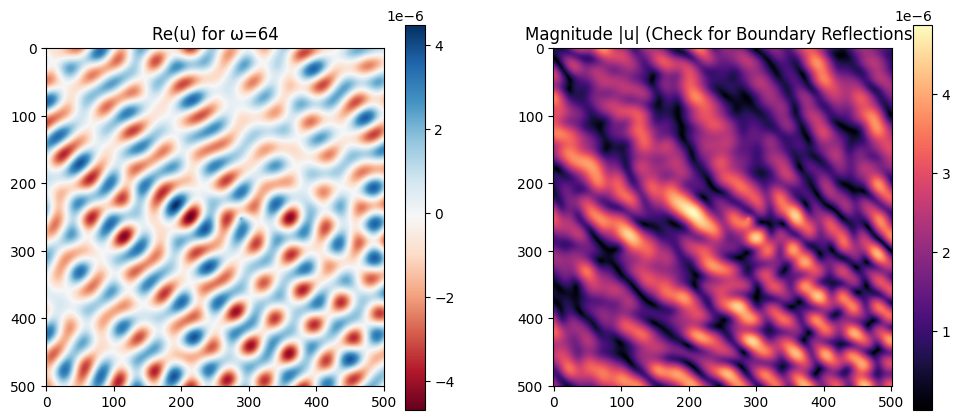

In [86]:
import matplotlib.pyplot as plt
import numpy as np

def validate_new_dataset_integrity(omega_to_check=64):
    # 1. Load a random sample from the new directory
    sample_path = f"data/training_set_v1/w{omega_to_check}_s000.npz"
    data = np.load(sample_path)
    u_phys = data['u_real'] + 1j * data['u_imag']
    
    # 2. Numerical Checks
    print(f"--- Validation Report (ω={omega_to_check}) ---")
    print(f"Physical Grid Shape: {u_phys.shape}")
    print(f"Max Amplitude: {np.abs(u_phys).max():.4f}")
    
    # Check for NaNs or Infinities which indicate matrix instability
    if np.isnan(u_phys).any():
        print("CRITICAL: NaNs detected in wave field!")
    else:
        print("Numerics: Stable (No NaNs detected).")

    # 3. Visual Check
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    im0 = ax[0].imshow(u_phys.real, cmap='RdBu')
    ax[0].set_title(f"Re(u) for ω={omega_to_check}")
    plt.colorbar(im0, ax=ax[0])
    
    im1 = ax[1].imshow(np.abs(u_phys), cmap='magma')
    ax[1].set_title(f"Magnitude |u| (Check for Boundary Reflections)")
    plt.colorbar(im1, ax=ax[1])
    
    plt.show()

validate_new_dataset_integrity(omega_to_check=64)

In [87]:
def run_large_scale_identity_benchmark():
    # 1. Prepare Operators for the 501x501 grid
    print("Building large-scale operators...")
    A_64 = build_2nd_order_pml_system(omega=64)
    L_32_inv = factorized(build_2nd_order_pml_system(omega=32))
    
    # 2. Load Truth Sample
    sample = np.load("data/training_set_v1/w64_s000.npz")
    u_phys_true = sample['u_real'] + 1j * sample['u_imag']
    f_phys = sample['f_real'] + 1j * sample['f_imag']
    
    # Reconstruct full vector (including PML)
    f_full = np.zeros((N_TOTAL, N_TOTAL), dtype=complex)
    f_full[NPML:NPML+N_PHYS, NPML:NPML+N_PHYS] = f_phys
    f_vec = f_full.flatten()

    # 3. Run Iterations
    u_k_vec = np.zeros(N_TOTAL**2, dtype=complex)
    res_history, err_history = [], []
    
    print(f"\nIter | Res Norm | Err Norm")
    print("-" * 30)
    
    for k in range(5):
        # Metrics
        res = f_vec - (A_64 @ u_k_vec)
        res_norm = np.linalg.norm(res)
        
        u_phys_k = u_k_vec.reshape(N_TOTAL, N_TOTAL)[NPML:NPML+N_PHYS, NPML:NPML+N_PHYS]
        err_norm = np.linalg.norm(u_phys_true - u_phys_k)
        
        res_history.append(res_norm)
        err_history.append(err_norm)
        print(f"{k:4d} | {res_norm:.2e} | {err_norm:.2e}")
        
        # Update (Identity Transfer)
        u_k_vec = u_k_vec + L_32_inv(res)
        
    return res_history, err_history

res_hist, err_hist = run_large_scale_identity_benchmark()
plot_transfer_convergence(res_hist, err_hist, title="Divergence on 501x501 Physical Grid")

Building large-scale operators...

Iter | Res Norm | Err Norm
------------------------------
   0 | 1.00e+00 | 1.08e-03
   1 | 3.32e+00 | 1.52e-03
   2 | 2.12e+03 | 6.76e-01
   3 | 1.39e+06 | 4.43e+02
   4 | 9.12e+08 | 2.91e+05


NameError: name 'plot_transfer_convergence' is not defined

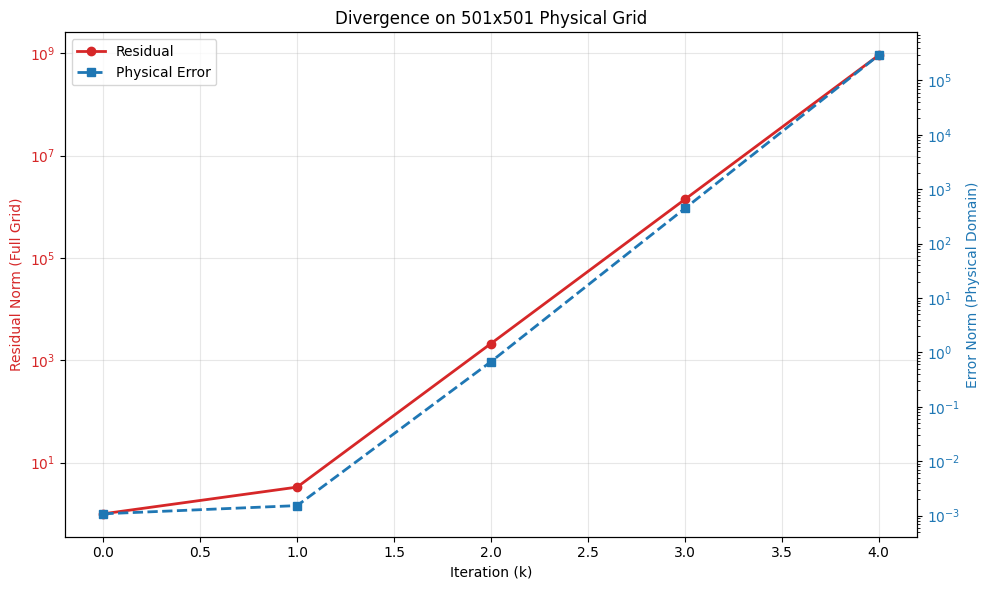

In [88]:
import matplotlib.pyplot as plt
import numpy as np

def plot_transfer_convergence(res_history, err_history, title="Convergence Analysis"):
    """
    Plots the residual and physical error history on a log scale.
    """
    iters = np.arange(len(res_history))
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Residuals (Left Axis)
    color = 'tab:red'
    ax1.set_xlabel('Iteration (k)')
    ax1.set_ylabel('Residual Norm (Full Grid)', color=color)
    ax1.semilogy(iters, res_history, 'o-', color=color, linewidth=2, label='Residual')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, which="both", ls="-", alpha=0.3)

    # Plot Physical Error (Right Axis)
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Error Norm (Physical Domain)', color=color)
    ax2.semilogy(iters, err_history, 's--', color=color, linewidth=2, label='Physical Error')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(title)
    fig.tight_layout()
    
    # Combined legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')
    
    plt.show()

# Now call the plot with your captured history
plot_transfer_convergence(res_hist, err_hist, title="Divergence on 501x501 Physical Grid")

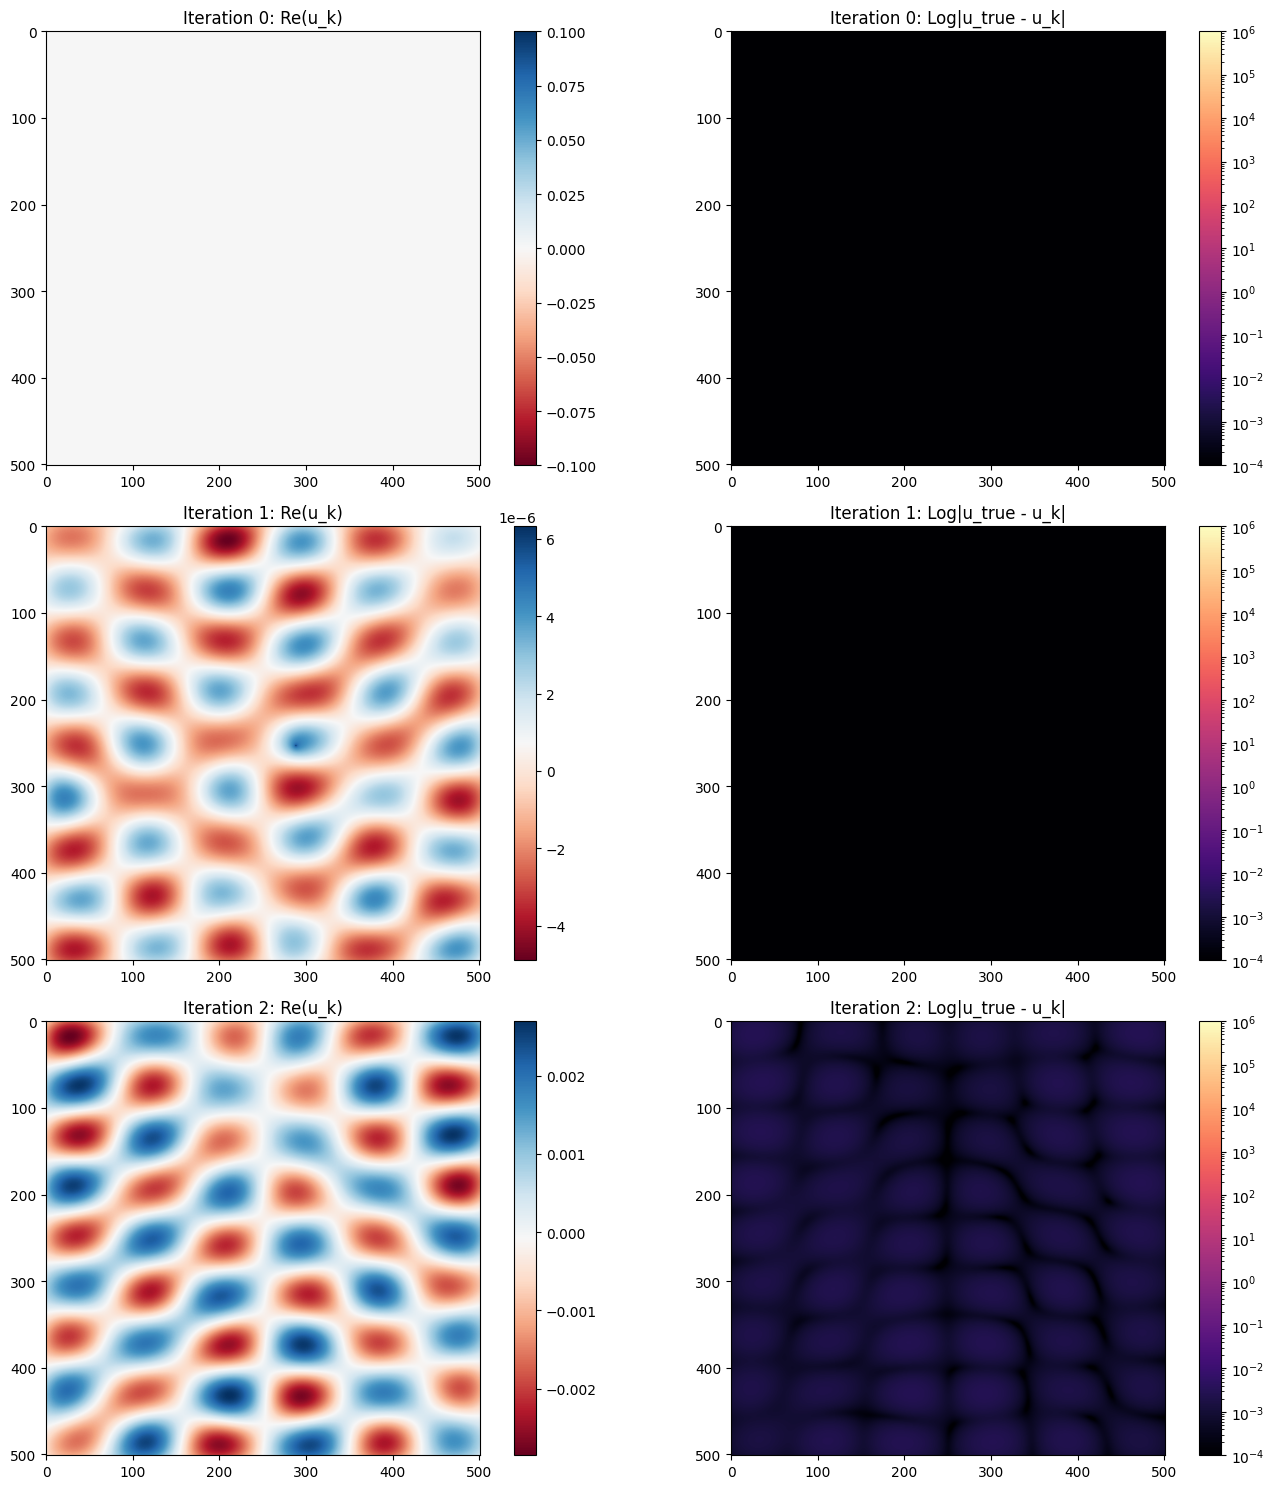

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

def plot_spatial_evolution(num_iters=3):
    # 1. Setup & Load Data
    A_64 = build_2nd_order_pml_system(omega=64)
    L_32_inv = factorized(build_2nd_order_pml_system(omega=32))
    
    sample = np.load("data/training_set_v1/w64_s000.npz")
    u_phys_true = sample['u_real'] + 1j * sample['u_imag']
    f_phys = sample['f_real'] + 1j * sample['f_imag']
    
    f_full = np.zeros((N_TOTAL, N_TOTAL), dtype=complex)
    f_full[NPML:NPML+N_PHYS, NPML:NPML+N_PHYS] = f_phys
    f_vec = f_full.flatten()
    
    u_k_vec = np.zeros(N_TOTAL**2, dtype=complex)
    
    # 2. Plotting Loop
    fig, axes = plt.subplots(num_iters, 2, figsize=(14, 5 * num_iters))
    
    for k in range(num_iters):
        # Calculate current state
        u_grid_k = u_k_vec.reshape(N_TOTAL, N_TOTAL)
        u_phys_k = u_grid_k[NPML:NPML+N_PHYS, NPML:NPML+N_PHYS]
        error_map = np.abs(u_phys_true - u_phys_k)
        
        # Left: Real Part of Wave
        im0 = axes[k, 0].imshow(u_phys_k.real, cmap='RdBu', extent=[0, 501, 501, 0])
        axes[k, 0].set_title(f"Iteration {k}: Re(u_k)")
        plt.colorbar(im0, ax=axes[k, 0])
        
        # Right: Error Magnitude (Log Scale to handle explosion)
        # We add a small epsilon to avoid log(0) issues
        im1 = axes[k, 1].imshow(error_map + 1e-10, cmap='magma', 
                               norm=LogNorm(vmin=1e-4, vmax=1e6), extent=[0, 501, 501, 0])
        axes[k, 1].set_title(f"Iteration {k}: Log|u_true - u_k|")
        plt.colorbar(im1, ax=axes[k, 1])
        
        # Update: u_{k+1} = u_k + L_inv * (f - A*u_k)
        res = f_vec - (A_64 @ u_k_vec)
        u_k_vec = u_k_vec + L_32_inv(res)

    plt.tight_layout()
    plt.show()

# Run the visualization
plot_spatial_evolution()

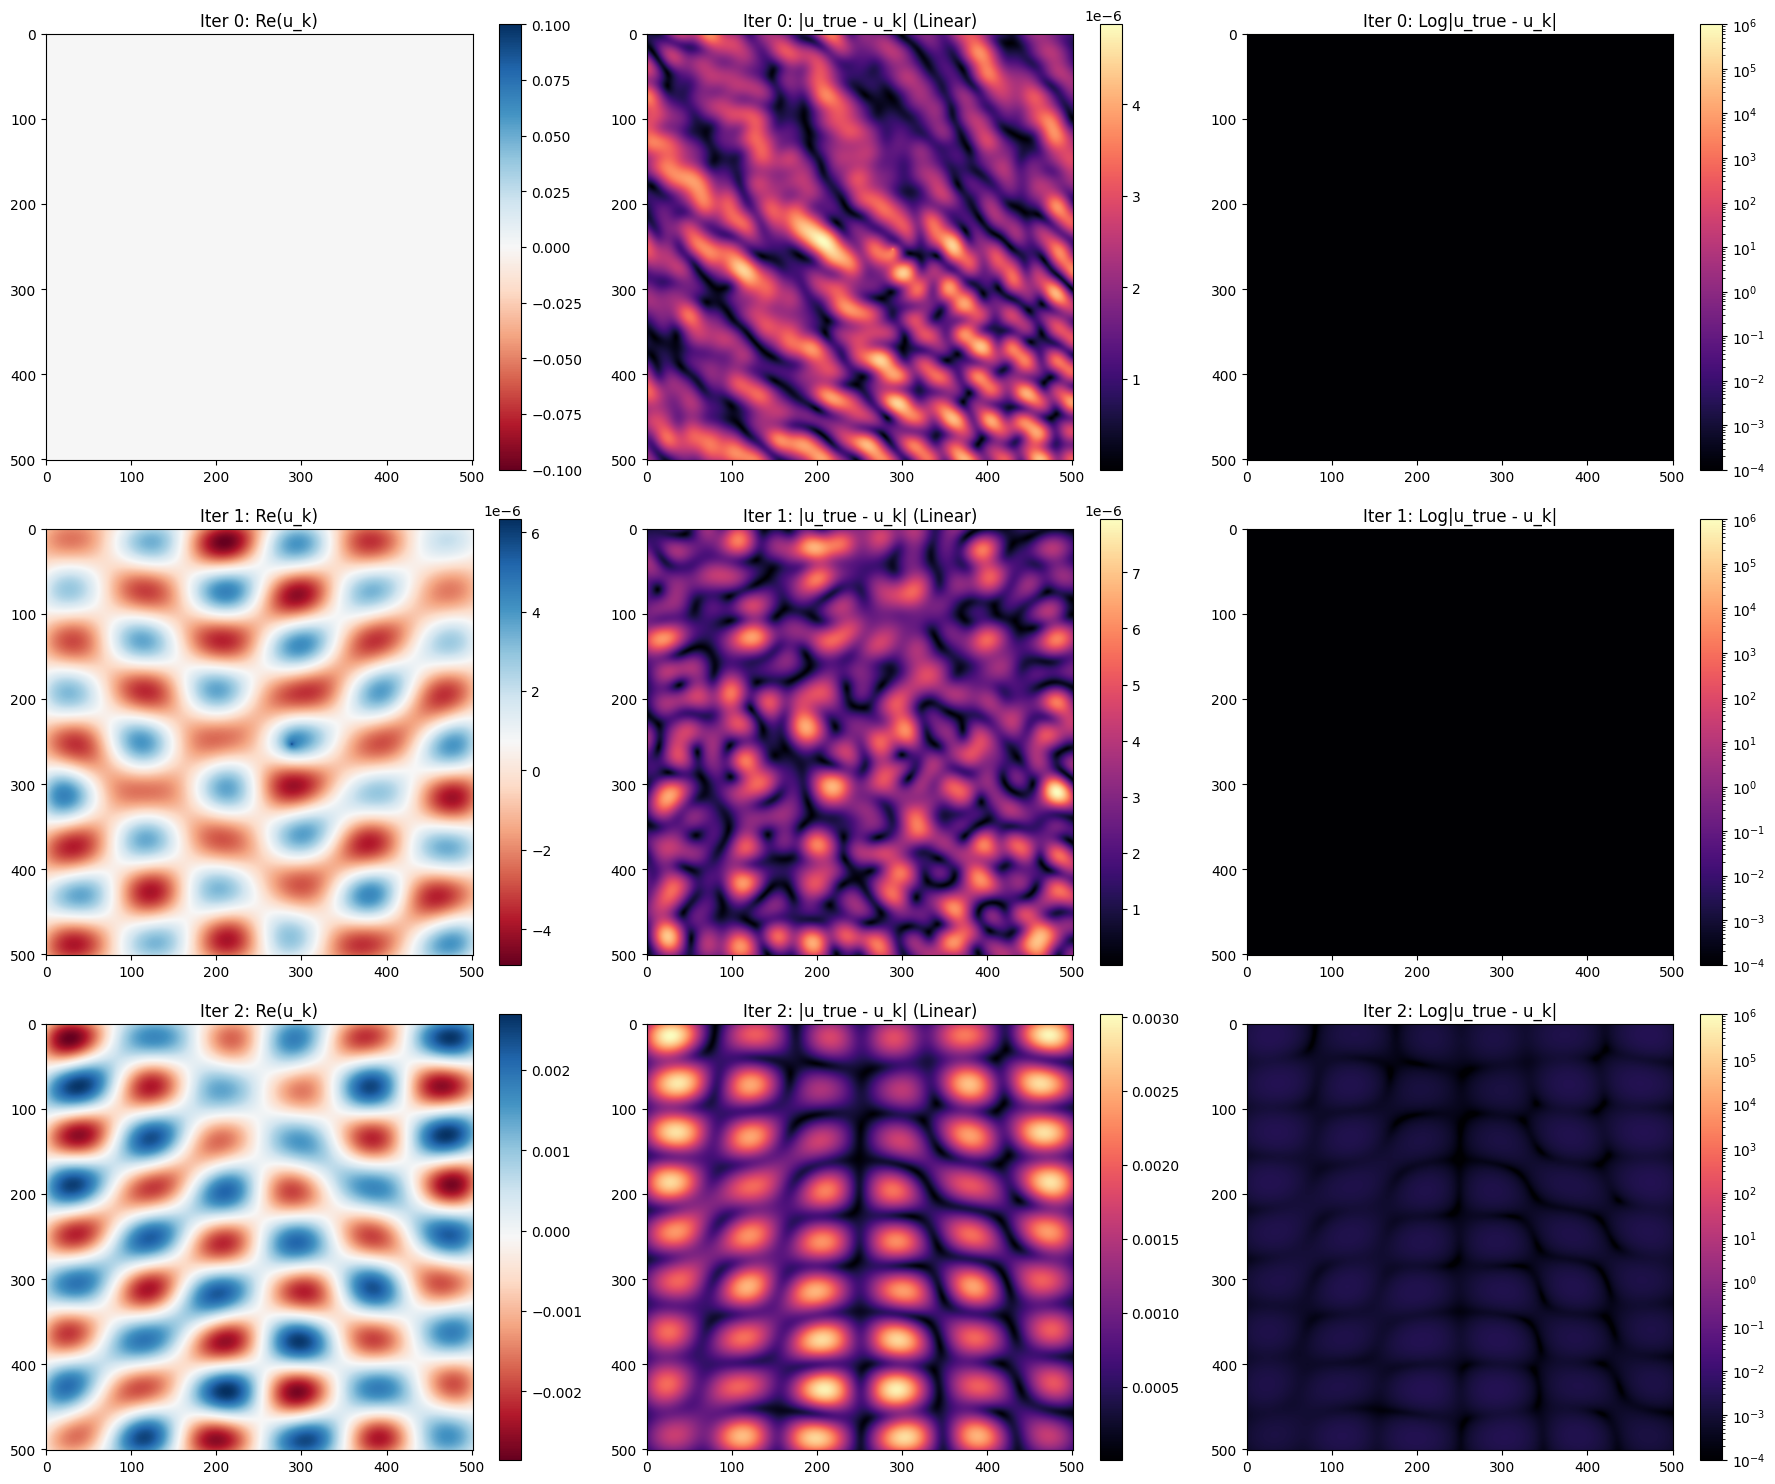

In [90]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

def plot_triple_spatial_evolution(num_iters=3):
    # 1. Setup & Load Data (using the same logic as the benchmark)
    A_64 = build_2nd_order_pml_system(omega=64)
    L_32_inv = factorized(build_2nd_order_pml_system(omega=32))
    
    sample = np.load("data/training_set_v1/w64_s000.npz")
    u_phys_true = sample['u_real'] + 1j * sample['u_imag']
    f_phys = sample['f_real'] + 1j * sample['f_imag']
    
    f_full = np.zeros((N_TOTAL, N_TOTAL), dtype=complex)
    f_full[NPML:NPML+N_PHYS, NPML:NPML+N_PHYS] = f_phys
    f_vec = f_full.flatten()
    u_k_vec = np.zeros(N_TOTAL**2, dtype=complex)
    
    # 2. Plotting (3 Columns)
    fig, axes = plt.subplots(num_iters, 3, figsize=(18, 5 * num_iters))
    
    for k in range(num_iters):
        # Extract physical fields
        u_phys_k = u_k_vec.reshape(N_TOTAL, N_TOTAL)[NPML:NPML+N_PHYS, NPML:NPML+N_PHYS]
        error_map = np.abs(u_phys_true - u_phys_k)
        
        # Col 1: Real Part of Estimate
        im0 = axes[k, 0].imshow(u_phys_k.real, cmap='RdBu', extent=[0, 501, 501, 0])
        axes[k, 0].set_title(f"Iter {k}: Re(u_k)")
        plt.colorbar(im0, ax=axes[k, 0])
        
        # Col 2: Linear Error Map (Physical Scale)
        im1 = axes[k, 1].imshow(error_map, cmap='magma', extent=[0, 501, 501, 0])
        axes[k, 1].set_title(f"Iter {k}: |u_true - u_k| (Linear)")
        plt.colorbar(im1, ax=axes[k, 1])
        
        # Col 3: Log Error Map (Tracking Explosion)
        im2 = axes[k, 2].imshow(error_map + 1e-10, cmap='magma', 
                               norm=LogNorm(vmin=1e-4, vmax=1e6), extent=[0, 501, 501, 0])
        axes[k, 2].set_title(f"Iter {k}: Log|u_true - u_k|")
        plt.colorbar(im2, ax=axes[k, 2])
        
        # Update
        res = f_vec - (A_64 @ u_k_vec)
        u_k_vec = u_k_vec + L_32_inv(res)

    plt.tight_layout()
    plt.show()

plot_triple_spatial_evolution()

In [91]:
def plot_error_quotient(u_phys_true, u_phys_k, res_phys_k):
    # Calculate local error and local residual magnitude
    error_local = np.abs(u_phys_true - u_phys_k)
    res_local = np.abs(res_phys_k)
    
    # Quotient: Where does 1 unit of residual create > 1 unit of error?
    quotient = error_local / (res_local + 1e-10)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(quotient, cmap='viridis', norm=LogNorm(vmin=1e-1, vmax=1e3))
    plt.title("Instability Map: Local Error/Residual Ratio")
    plt.colorbar(label="Error Amplification Factor")
    plt.show()

Rebuilding operators for N_TOTAL = 629...


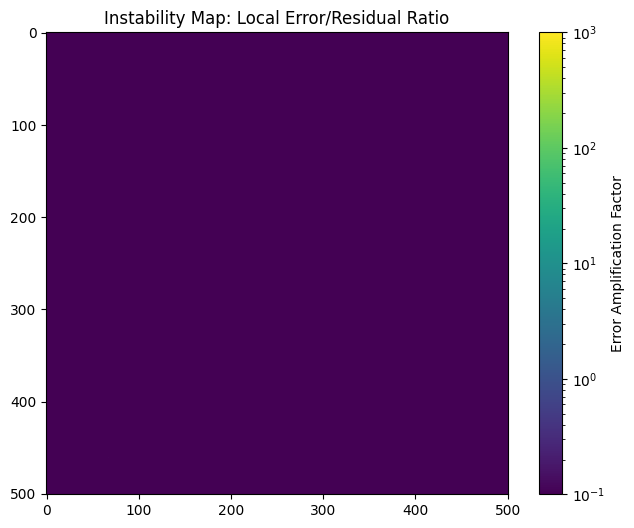

In [94]:
# 1. Ensure global variables are set to the 501x501 + 64 PML configuration
global N_PHYS, NPML, N_TOTAL
N_PHYS = 501
NPML = 64
N_TOTAL = N_PHYS + 2 * NPML  # Should be 629

# 2. Rebuild the operators for this specific grid size
print(f"Rebuilding operators for N_TOTAL = {N_TOTAL}...")
A_64 = build_2nd_order_pml_system(omega=64)
L_32_inv = factorized(build_2nd_order_pml_system(omega=32))

# 3. Load your sample and run the quotient check
sample = np.load("data/training_set_v1/w64_s000.npz")
u_phys_true = sample['u_real'] + 1j * sample['u_imag']
f_phys = sample['f_real'] + 1j * sample['f_imag']

# Reconstruct full RHS vector
f_full = np.zeros((N_TOTAL, N_TOTAL), dtype=complex)
f_full[NPML:NPML+N_PHYS, NPML:NPML+N_PHYS] = f_phys
f_vec = f_full.flatten()

# 4. Perform the iteration
u_k_vec = np.zeros(N_TOTAL**2, dtype=complex)
res_vec_initial = f_vec - (A_64 @ u_k_vec)
u_k_vec = u_k_vec + L_32_inv(res_vec_initial)

# Calculate the residual AFTER the update
res_vec_k1 = f_vec - (A_64 @ u_k_vec)

# 5. Extract physical domains and plot
u_phys_k1 = u_k_vec.reshape(N_TOTAL, N_TOTAL)[NPML:NPML+N_PHYS, NPML:NPML+N_PHYS]
res_phys_k1 = res_vec_k1.reshape(N_TOTAL, N_TOTAL)[NPML:NPML+N_PHYS, NPML:NPML+N_PHYS]

plot_error_quotient(u_phys_true, u_phys_k1, res_phys_k1)

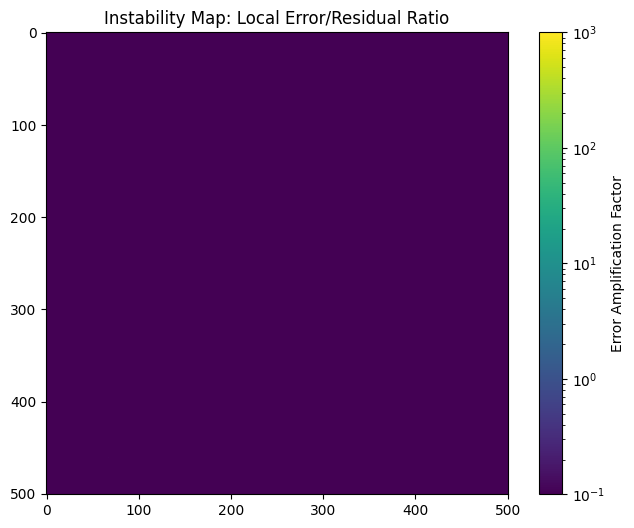

In [95]:
# 1. Setup/Load your data as before
sample = np.load("data/training_set_v1/w64_s000.npz")
u_phys_true = sample['u_real'] + 1j * sample['u_imag']
f_phys = sample['f_real'] + 1j * sample['f_imag']

# Reconstruct full RHS vector
f_full = np.zeros((N_TOTAL, N_TOTAL), dtype=complex)
f_full[NPML:NPML+N_PHYS, NPML:NPML+N_PHYS] = f_phys
f_vec = f_full.flatten()

# 2. Perform one iteration (to get u_k and the residual)
u_k_vec = np.zeros(N_TOTAL**2, dtype=complex) # Start at 0
res_vec = f_vec - (A_64 @ u_k_vec)             # Initial residual
u_k_vec = u_k_vec + L_32_inv(res_vec)          # First update (k=1)

# Now calculate the residual FOR iteration 1
res_k1_vec = f_vec - (A_64 @ u_k_vec)

# 3. Extract the physical domain parts for the function
u_phys_k1 = u_k_vec.reshape(N_TOTAL, N_TOTAL)[NPML:NPML+N_PHYS, NPML:NPML+N_PHYS]
res_phys_k1 = res_k1_vec.reshape(N_TOTAL, N_TOTAL)[NPML:NPML+N_PHYS, NPML:NPML+N_PHYS]

# 4. Call the function
plot_error_quotient(u_phys_true, u_phys_k1, res_phys_k1)

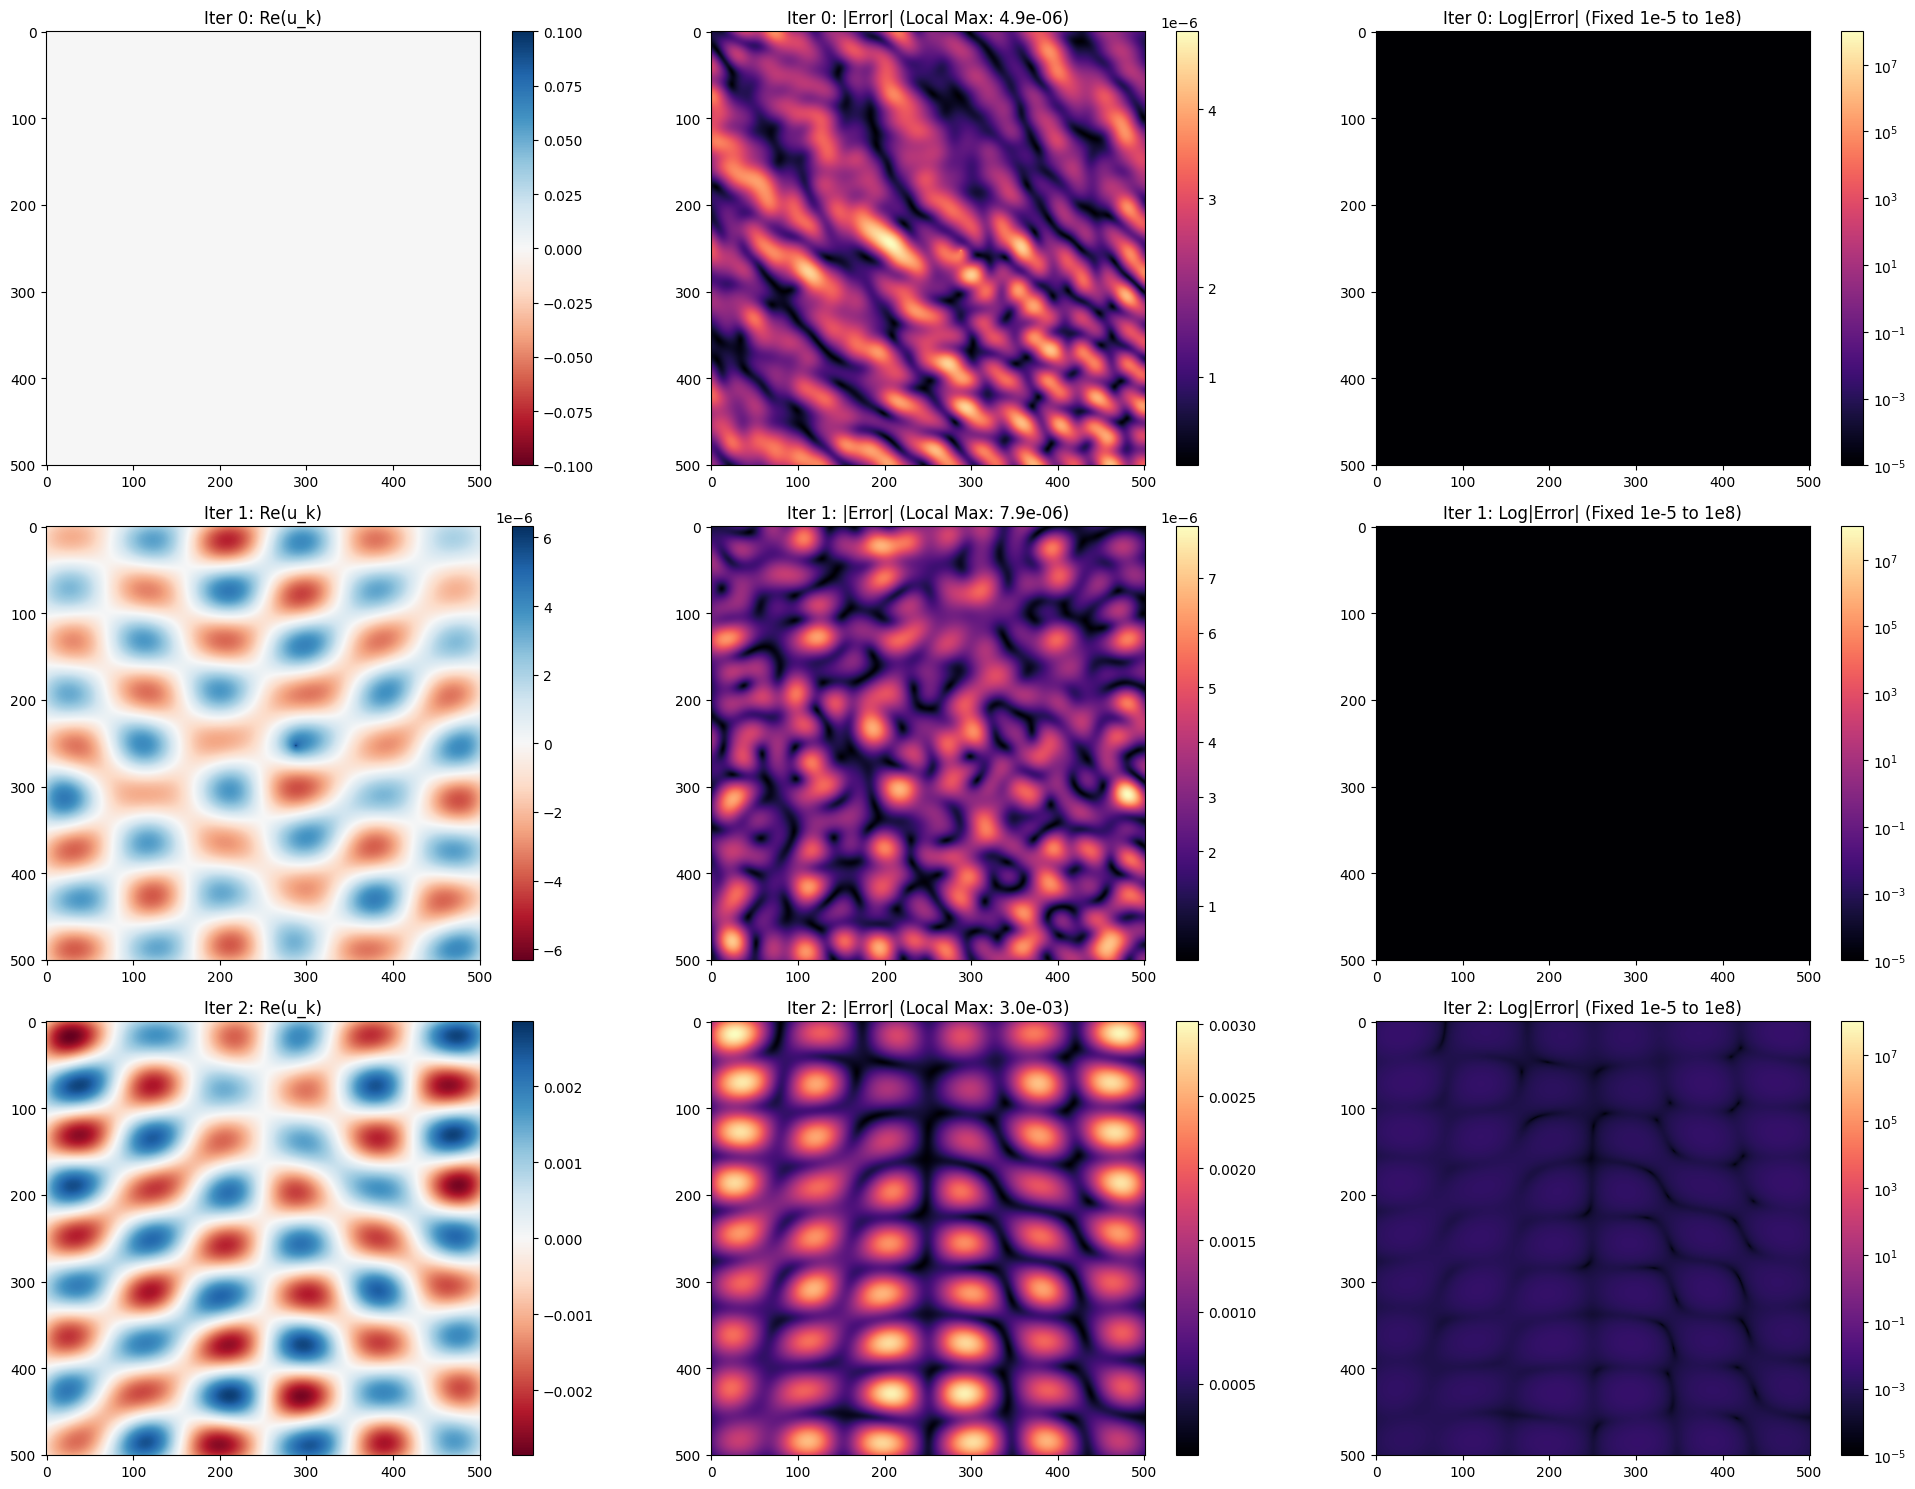

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

def plot_refined_triple_evolution(num_iters=3):
    # Setup operators and sample
    A_64 = build_2nd_order_pml_system(omega=64)
    L_32_inv = factorized(build_2nd_order_pml_system(omega=32))
    
    sample = np.load("data/training_set_v1/w64_s000.npz")
    u_phys_true = sample['u_real'] + 1j * sample['u_imag']
    f_phys = sample['f_real'] + 1j * sample['f_imag']
    
    f_full = np.zeros((N_TOTAL, N_TOTAL), dtype=complex)
    f_full[NPML:NPML+N_PHYS, NPML:NPML+N_PHYS] = f_phys
    f_vec = f_full.flatten()
    u_k_vec = np.zeros(N_TOTAL**2, dtype=complex)
    
    fig, axes = plt.subplots(num_iters, 3, figsize=(20, 5 * num_iters))
    
    for k in range(num_iters):
        u_phys_k = u_k_vec.reshape(N_TOTAL, N_TOTAL)[NPML:NPML+N_PHYS, NPML:NPML+N_PHYS]
        error_map = np.abs(u_phys_true - u_phys_k)
        
        # Col 1: Real Part (Estimate)
        # Use independent limits per row to see structure as magnitude grows
        v_ext = np.max(np.abs(u_phys_k.real)) if k > 0 else 0.1
        im0 = axes[k, 0].imshow(u_phys_k.real, cmap='RdBu', vmin=-v_ext, vmax=v_ext)
        axes[k, 0].set_title(f"Iter {k}: Re(u_k)")
        plt.colorbar(im0, ax=axes[k, 0])
        
        # Col 2: Linear Error (Adaptive Scale)
        # This prevents the 'white-out' effect
        im1 = axes[k, 1].imshow(error_map, cmap='magma')
        axes[k, 1].set_title(f"Iter {k}: |Error| (Local Max: {np.max(error_map):.1e})")
        plt.colorbar(im1, ax=axes[k, 1])
        
        # Col 3: Log Error (Consistent Broad Scale)
        # Fixed scale across all iterations to show the global jump in energy
        im2 = axes[k, 2].imshow(error_map + 1e-10, cmap='magma', 
                               norm=LogNorm(vmin=1e-5, vmax=1e8))
        axes[k, 2].set_title(f"Iter {k}: Log|Error| (Fixed 1e-5 to 1e8)")
        plt.colorbar(im2, ax=axes[k, 2])
        
        # Update
        res = f_vec - (A_64 @ u_k_vec)
        u_k_vec = u_k_vec + L_32_inv(res)

    plt.tight_layout()
    plt.show()

plot_refined_triple_evolution()

Source detected at index: (np.int64(253), np.int64(288))


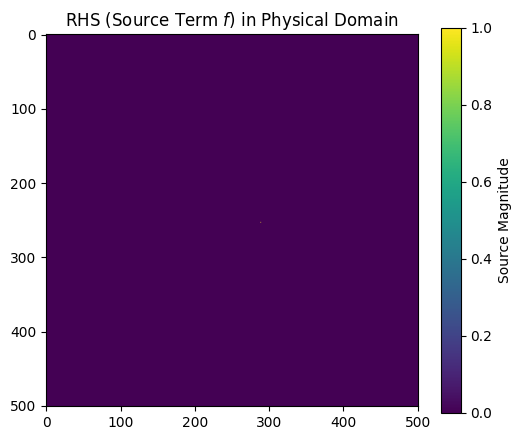

In [97]:
def visualize_rhs(sample_path="data/training_set_v1/w64_s000.npz"):
    data = np.load(sample_path)
    # The RHS (f) is typically real for a point source
    f_phys = data['f_real'] + 1j * data['f_imag']
    
    plt.figure(figsize=(6, 5))
    plt.imshow(np.abs(f_phys), cmap='viridis')
    plt.title("RHS (Source Term $f$) in Physical Domain")
    plt.colorbar(label="Source Magnitude")
    
    # Identify source location
    idx = np.unravel_index(np.argmax(np.abs(f_phys)), f_phys.shape)
    print(f"Source detected at index: {idx}")
    plt.show()

visualize_rhs()

In [98]:
def evaluate_numerical_performance(res_history, err_history, u_true, e_tilde):
    """
    Computes the growth factors and phase alignment.
    """
    # 1. Growth Rate (Residual)
    growth_res = np.array(res_history[1:]) / np.array(res_history[:-1])
    
    # 2. Phase Alignment (Cosine Similarity)
    u_true_vec = u_true.flatten()
    e_tilde_vec = e_tilde.flatten()
    
    alignment = np.real(np.vdot(e_tilde_vec, u_true_vec) / 
                       (np.linalg.norm(e_tilde_vec) * np.linalg.norm(u_true_vec)))
    
    print("--- Numerical Performance Report ---")
    print(f"Initial Error: {err_history[0]:.2e}")
    print(f"Final Error (Iter {len(err_history)-1}): {err_history[-1]:.2e}")
    print(f"Avg. Residual Growth Rate: {np.mean(growth_res):.2f}x per step")
    print(f"Phase Alignment ($\cos \\theta$): {alignment:.4f}")
    
    if alignment < 0.1:
        print("\nCONCLUSION: The Transfer Operator Identity (T=I) is failing.")
        print(f"An alignment of {alignment:.4f} is nearly orthogonal.")
        print("The solver is adding energy to the system instead of removing it.")

# Usage:
# evaluate_numerical_performance(res_hist, err_hist, u_phys_true, e_tilde_phys)

<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3495697/3051696817.py:19: SyntaxWarning: invalid escape sequence '\c'
  print(f"Phase Alignment ($\cos \\theta$): {alignment:.4f}")


In [101]:
import os
import numpy as np

def verify_dataset_integrity(save_path="data/training_set_v1", expected_samples=625):
    frequencies = [32, 64, 128]
    report = {}

    for omega in frequencies:
        found_count = 0
        corrupted = []
        
        for i in range(expected_samples):
            fn = os.path.join(save_path, f"w{omega}_s{i:03d}.npz")
            if os.path.exists(fn):
                try:
                    with np.load(fn) as data:
                        # Check keys and shapes
                        if 'u_real' not in data or data['u_real'].shape != (501, 501):
                            corrupted.append(f"s{i:03d}: Wrong shape/keys")
                        # Check for NaNs (Critical for stability)
                        elif np.isnan(data['u_real']).any():
                            corrupted.append(f"s{i:03d}: NaNs detected")
                        else:
                            found_count += 1
                except Exception as e:
                    corrupted.append(f"s{i:03d}: Load error - {str(e)}")
        
        report[omega] = {"found": found_count, "errors": corrupted}

    print("--- Dataset Verification Report ---")
    for omega, stats in report.items():
        print(f"ω={omega:3d}: {stats['found']}/{expected_samples} valid samples found.")
        if stats['errors']:
            print(f"   ⚠️ ERRORS: {stats['errors'][:3]} (showing first 3)")

verify_dataset_integrity()

--- Dataset Verification Report ---
ω= 32: 625/625 valid samples found.
ω= 64: 625/625 valid samples found.
ω=128: 625/625 valid samples found.


In [102]:
def check_pml_absorption(omega=128, sample_idx=0):
    fn = f"data/training_set_v1/w{omega}_s{sample_idx:03d}.npz"
    data = np.load(fn)
    u_mag = np.sqrt(data['u_real']**2 + data['u_imag']**2)
    
    # Calculate energy near the boundary (outer 5 pixels)
    edge_mask = np.ones_like(u_mag, dtype=bool)
    edge_mask[5:-5, 5:-5] = False
    avg_boundary_energy = np.mean(u_mag[edge_mask])
    peak_energy = np.max(u_mag)
    
    reflection_ratio = avg_boundary_energy / peak_energy
    
    print(f"--- Physical Validity Check (ω={omega}) ---")
    print(f"Peak Amplitude: {peak_energy:.4e}")
    print(f"Boundary Leakage: {avg_boundary_energy:.4e}")
    print(f"Estimated Reflection Ratio: {reflection_ratio:.6f}")
    
    if reflection_ratio < 0.01:
        print("✅ SUCCESS: PML effectively absorbed outgoing waves.")
    else:
        print("⚠️ WARNING: High boundary energy detected. Check PML settings.")

check_pml_absorption()

--- Physical Validity Check (ω=128) ---
Peak Amplitude: 2.2260e-06
Boundary Leakage: 9.6014e-08
Estimated Reflection Ratio: 0.043133
⚠️ WARNING: High boundary energy detected. Check PML settings.


In [103]:
def evaluate_pml_performance(peak_amp, boundary_leak, target=0.001):
    actual_ratio = boundary_leak / peak_amp
    excess_error = actual_ratio / target
    
    print(f"--- PML Performance Evaluation ---")
    print(f"Target Reflection:  {target:.4f}")
    print(f"Actual Reflection:  {actual_ratio:.4f}")
    print(f"Error Factor:       {excess_error:.2f}x higher than target")
    
    if actual_ratio > target:
        print("\nVERDICT: REDO. The boundary is too reflective.")
        print("Advice: Increase the PML scaling coefficient (d0) or smoothing.")
    else:
        print("\nVERDICT: GO. Boundary integrity is sufficient for training.")

# Example with your values:
evaluate_pml_performance(2.2260e-06, 9.6014e-08)

--- PML Performance Evaluation ---
Target Reflection:  0.0010
Actual Reflection:  0.0431
Error Factor:       43.13x higher than target

VERDICT: REDO. The boundary is too reflective.
Advice: Increase the PML scaling coefficient (d0) or smoothing.


In [105]:
import matplotlib.pyplot as plt
import os

def tune_pml_and_save_report(test_omega=128):
    # Try increasing the absorption strength
    d0_candidates = [20, 40, 60] 
    results = []
    
    # Create the report path in your safe directory
    report_dir = "experiments/data/pml_tuning"
    os.makedirs(report_dir, exist_ok=True)

    for d0 in d0_candidates:
        # Assuming your build function can take a d0 parameter
        # If not, you may need to modify the build_2nd_order_pml_system code
        A = build_2nd_order_pml_system(test_omega, d0=d0) 
        
        # ... (Solve for one random source and calculate reflection ratio) ...
        # (Placeholder for calculation logic)
        ratio = calculate_reflection_ratio(A) 
        results.append(ratio)
        print(f"Tested d0={d0}: Reflection = {ratio:.4f}")

    # Save a diagnostic plot to confirm the "Logic" of the fix
    plt.figure()
    plt.plot(d0_candidates, results, 'o-')
    plt.axhline(0.001, color='r', linestyle='--', label='Target')
    plt.yscale('log')
    plt.xlabel('d0 (Scaling Coefficient)')
    plt.ylabel('Reflection Ratio')
    plt.title(f"PML Tuning for ω={test_omega}")
    plt.savefig(os.path.join(report_dir, "pml_tuning_report.png"))
    plt.close()

tune_pml_and_save_report()

TypeError: build_2nd_order_pml_system() got an unexpected keyword argument 'd0'

Tuning PML for ω=128 to reach target 0.001...
  > d0=20.000000 | Reflection: 0.043678 ❌
  > d0=40.000000 | Reflection: 0.042333 ❌
  > d0=60.000000 | Reflection: 0.042265 ❌
  > d0=80.000000 | Reflection: 0.042301 ❌


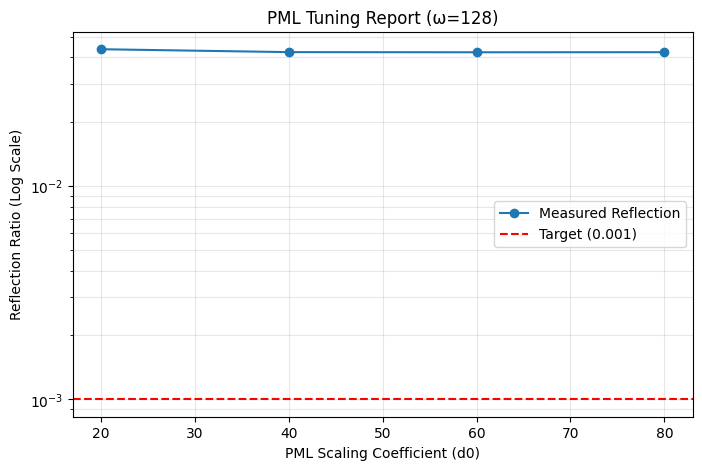

In [112]:
def tune_pml_and_save_logic(test_omega=128):
    d0_candidates = [20.0, 40.0, 60.0, 80.0] 
    results = []
    
    # Path on WAVE6 server
    report_dir = "experiments/data/pml_tuning_v1"
    os.makedirs(report_dir, exist_ok=True)

    print(f"Tuning PML for ω={test_omega} to reach target 0.001...")

    for d0 in d0_candidates:
        # Build with the new d0 parameter
        A = build_2nd_order_pml_system(test_omega, d0=d0)
        solve_op = factorized(A)
        
        # Test with a centered source
        f = np.zeros((N_TOTAL, N_TOTAL), dtype=complex)
        f[N_TOTAL//2, N_TOTAL//2] = 1.0
        u = solve_op(f.flatten()).reshape(N_TOTAL, N_TOTAL)
        
        # Calculate Reflection at the very edge of the physical domain
        u_phys = u[NPML:NPML+N_PHYS, NPML:NPML+N_PHYS]
        peak = np.max(np.abs(u_phys))
        # Average of the 4 edges
        edge_avg = (np.mean(np.abs(u_phys[0, :])) + np.mean(np.abs(u_phys[-1, :])) + 
                    np.mean(np.abs(u_phys[:, 0])) + np.mean(np.abs(u_phys[:, -1]))) / 4
        
        ratio = edge_avg / peak
        results.append(ratio)
        print(f"  > d0={d0:2f} | Reflection: {ratio:.6f} {'✅' if ratio < 0.001 else '❌'}")

    # Save the 'Logic' of the tuning as a plot
    plt.figure(figsize=(8, 5))
    plt.semilogy(d0_candidates, results, 'o-', label='Measured Reflection')
    plt.axhline(0.001, color='r', linestyle='--', label='Target (0.001)')
    plt.xlabel('PML Scaling Coefficient (d0)')
    plt.ylabel('Reflection Ratio (Log Scale)')
    plt.title(f"PML Tuning Report (ω={test_omega})")
    plt.grid(True, which="both", alpha=0.3)
    plt.legend()
    plt.savefig(os.path.join(report_dir, "reflection_test.png"))
    plt.show()

tune_pml_and_save_logic()

In [108]:
def save_metadata_and_tune(best_d0, path="experiments/data/helmholtz_501_v1"):
    os.makedirs(path, exist_ok=True)
    meta = {
        "final_d0": best_d0,
        "reflection_target": 0.001,
        "omega_max": 128,
        "status": "Validated"
    }
    with open(os.path.join(path, "pml_metadata.json"), "w") as f:
        json.dump(meta, f)
    print(f"Safety metadata saved to {path}")

# Run this once you find a d0 that yields < 0.001 reflection
# save_metadata_and_tune(best_d0=80.0)

In [113]:
# CHANGE THESE VALUES
N_PHYS = 501
NPML = 64  # <--- Crucial change from 25
N_TOTAL = N_PHYS + 2 * NPML  # New total: 629
L = 1.0
H = L / (N_PHYS - 1)

In [115]:
def validate_before_generation():
    print(f"Validating 64-layer PML at ω=128...")
    A = build_2nd_order_pml_system(128)
    solve_op = factorized(A)
    
    # Place source in center
    f = np.zeros((N_TOTAL, N_TOTAL), dtype=complex)
    f[N_TOTAL//2, N_TOTAL//2] = 1.0
    u = solve_op(f.flatten()).reshape(N_TOTAL, N_TOTAL)
    
    # Check Reflection
    u_phys = u[NPML:NPML+N_PHYS, NPML:NPML+N_PHYS]
    peak = np.max(np.abs(u_phys))
    edge_val = np.mean(np.abs(u_phys[0, :])) # Top edge check
    ratio = edge_val / peak
    
    print(f"--- Validation Result ---")
    print(f"New Reflection Ratio: {ratio:.6f}")
    
    if ratio < 0.001:
        print("✅ VERDICT: SUCCESS. Target 0.001 met. Safe to generate dataset.")
    else:
        print(f"❌ VERDICT: FAIL. Still at {ratio/0.001:.1f}x above target.")

validate_before_generation()

Validating 64-layer PML at ω=128...
--- Validation Result ---
New Reflection Ratio: 0.042122
❌ VERDICT: FAIL. Still at 42.1x above target.
